<a href="https://colab.research.google.com/github/konung00/DS_ML/blob/main/bank_additional_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import random
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

root_path = 'gdrive/My Drive/datasets/data/bank-additional-full.csv'
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

Mounted at /content/gdrive


#Pre-processing

In [ ]:
def nan_fill(df, col, val):
  """ Return DataFrame[column] with filled gaps """

  return df[col].apply(lambda x: val if pd.isnull(x) else x)


def col_info(df, col):
  """ Attribute analysis """
  sns.set(rc = {'figure.figsize':(15,8)})

  if df[col].dtypes == 'object':
    all_indexes = list(df[col].value_counts().index)
    print(df[col].value_counts(dropna=False))
    print('Count: ', df[col].count())
    print('Unique values:', df[col].nunique())
    print('NAN values in the column:', df[col].isnull().sum(axis=0))
    sns.countplot(data=df, y=col)
  else:
    fig, ax = plt.subplots()
    df[col].hist(ax=ax)
    ax.set_xlabel(col)
    plt.show()
    print('Count: ', df[col].count())
    print('Median: ', df[col].median())
    print('Mean: ', df[col].mean())
    print('Variance: ', df[col].var())
    print('Standart deviation: ', df[col].std())
    print('Max value: ', df[col].max())
    print('Min value: ', df[col].min())
    print('NAN values in the column: ', df[col].isnull().sum(axis=0))


#Data loading

In [ ]:
df = pd.read_csv(root_path, sep=";").replace('unknown', np.nan)
#df = pd.read_csv(root_path, sep=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
df.shape

(41188, 21)

______________________

#Exploratory data analysis:

Check for the duplicates:

In [ ]:
df = df.drop_duplicates()
df.shape

(41176, 21)

Duplicates were removed. Let's look at null values:

In [ ]:
df.isnull().mean() * 100

age                0.000000
job                0.801438
marital            0.194288
education          4.201477
default           20.876239
housing            2.404313
loan               2.404313
contact            0.000000
month              0.000000
day_of_week        0.000000
duration           0.000000
campaign           0.000000
pdays              0.000000
previous           0.000000
poutcome           0.000000
emp.var.rate       0.000000
cons.price.idx     0.000000
cons.conf.idx      0.000000
euribor3m          0.000000
nr.employed        0.000000
y                  0.000000
dtype: float64

As we can see there are no dramatically "empty" features, so we could proceed without changes. Let's deep dive to every single attribute:

##1. "Age" attribute:

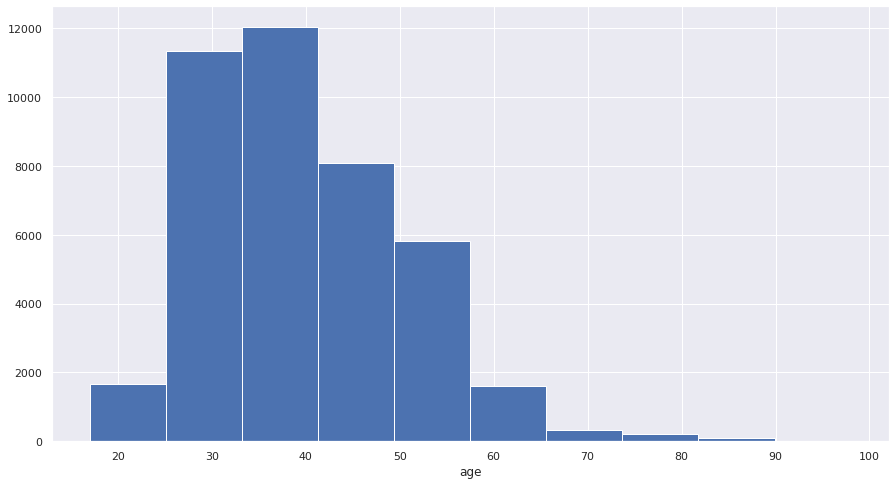

Count:  41176
Median:  38.0
Mean:  40.02380027200311
Variance:  108.59056893098968
Standart deviation:  10.420679868942797
Max value:  98
Min value:  17
NAN values in the column:  0


In [ ]:
col_info(df, 'age')

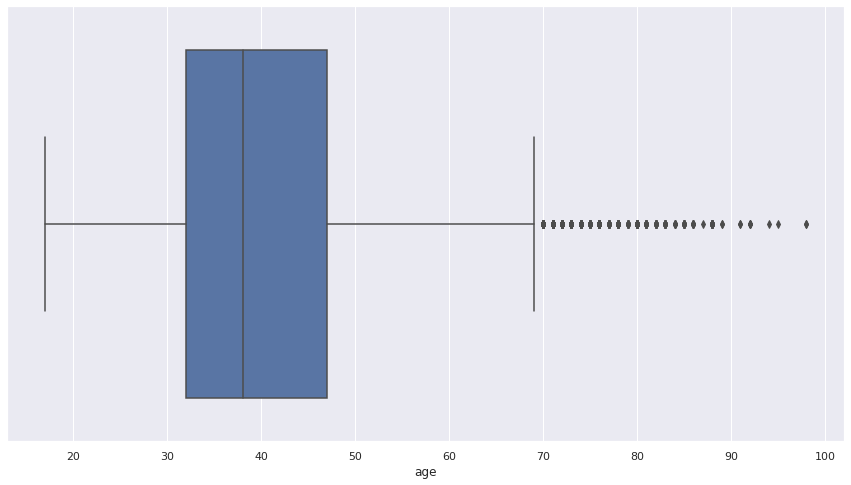

In [ ]:
sns.boxplot(x="age", data=df)

The destribution has a suspicious right tail. Values after 70 are posible outliers. Let's analys it trough interquartile range:

25-percentile: 32.0, 75-percentile: 47.0, IQR: 15.0, outlier range: [9.5, 69.5]


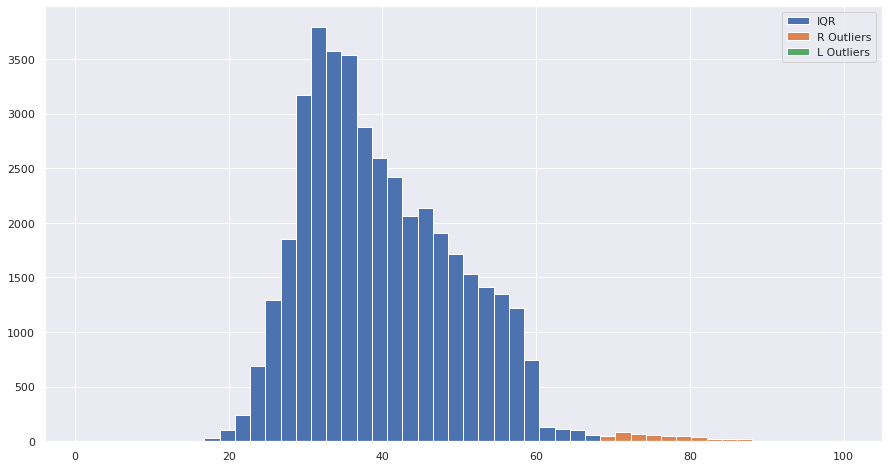

In [ ]:
perc25 = df.age.quantile(0.25)
perc75 = df.age.quantile(0.75)
IQR = perc75 - perc25
left = perc25 - 1.5 * IQR
right = perc75 + 1.5 * IQR
print(f"25-percentile: {perc25}, 75-percentile: {perc75}, IQR: {IQR}, outlier range: [{left}, {right}]")
df.age.loc[df.age.between(left, right)].hist(bins=50, range= (1, 100), label='IQR')
df.age.loc[df.age >= right].hist(alpha = 1, bins=50, range= (1, 100), label='R Outliers')
df.age.loc[df.age <= left].hist(alpha = 1, bins=50, range= (1, 100), label='L Outliers')
plt.legend()
plt.show()

The chart depicts the right tail as an outlier.

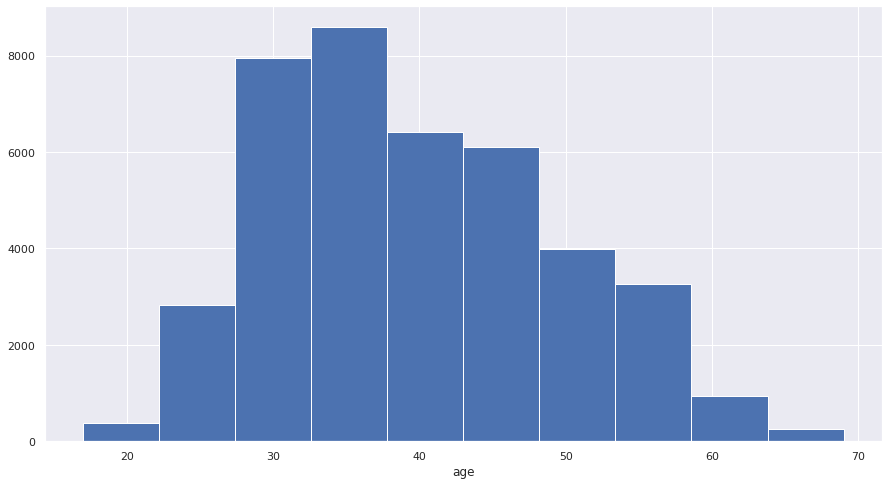

Count:  40708
Median:  38.0
Mean:  39.599390783138446
Variance:  93.61026027197872
Standart deviation:  9.675239545973977
Max value:  69
Min value:  17
NAN values in the column:  0


(40708, 21)

In [ ]:
df = df.loc[~df.age.isin(df.age.loc[df.age >= right])]
col_info(df, 'age')
df.shape

**Now the values standardized and there are no any type of outliers.**
______________________

## 2. "Education" attribute:

university.degree      12102
high.school             9478
basic.9y                6018
professional.course     5198
basic.4y                3935
basic.6y                2278
NaN                     1682
illiterate                17
Name: education, dtype: int64
Count:  39026
Unique values: 7
NAN values in the column: 1682


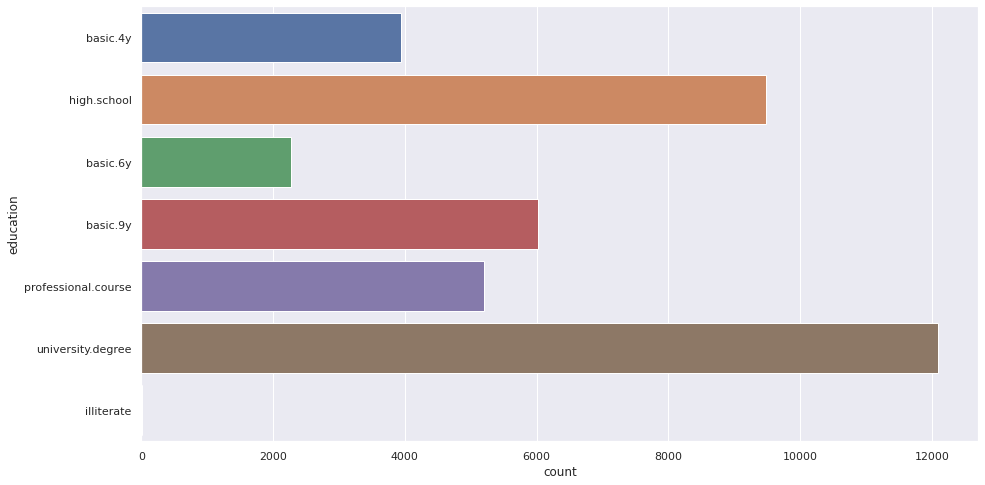

In [ ]:
col_info(df, 'education')

There are some gapes to be filled. Let's figure out age of people with NULL values:

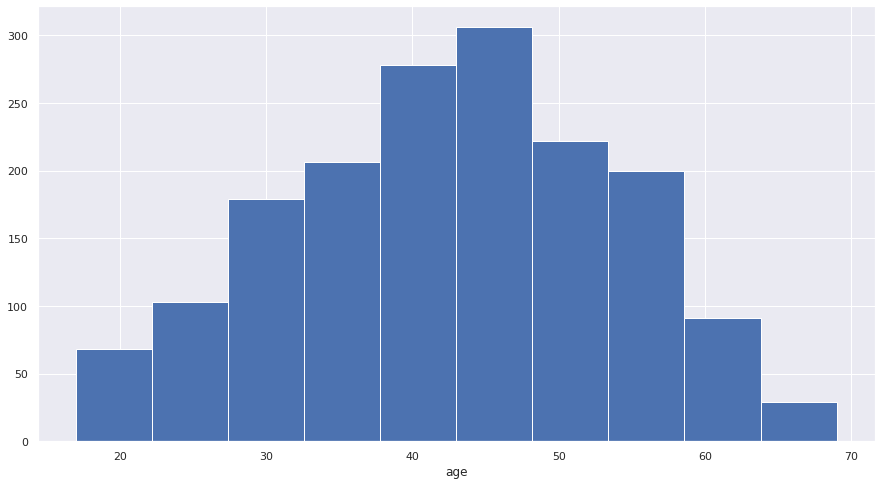

Count:  1682
Median:  43.0
Mean:  42.50237812128419
Variance:  124.61897114069897
Standart deviation:  11.163286753492404
Max value:  69
Min value:  17
NAN values in the column:  0


In [ ]:
col_info(df[pd.isnull(df.education)], 'age')

The chart depicts broad range of age. That means we cannot distinguish particular age group and gaps should be populated with several values. Let's compare it with job via the heatmap:

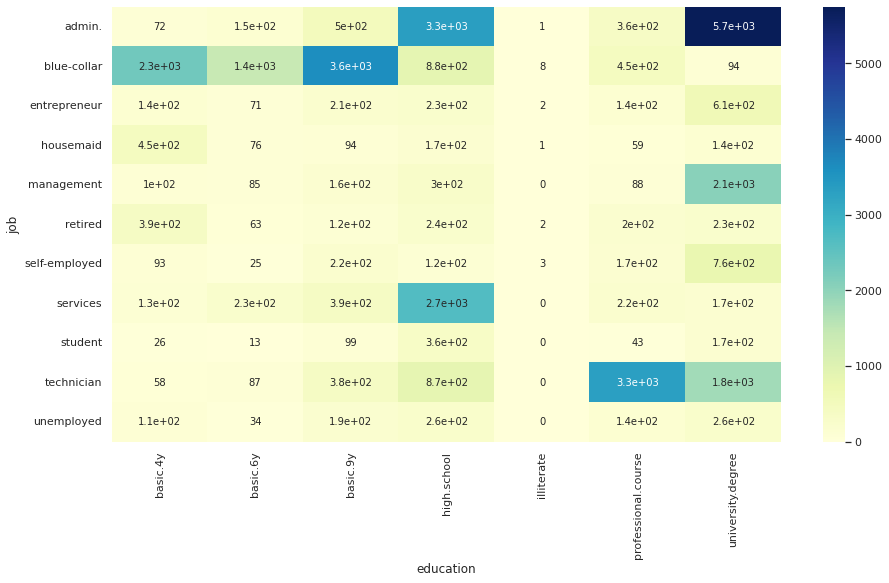

In [ ]:
sns.heatmap(pd.crosstab(df['job'], df['education']), annot=True, annot_kws={'size':10}, cmap="YlGnBu")

The heatmap depicts correlation between job and education that is obvious. "Admin.", "blue-collar", "technician" and "unemployed" cover several education values, the rest of others can be filled with mode. Let's calculate posible weights of education position according with job:

In [ ]:
undeg_admin = df.loc[(df['job'] == "admin.")&(df['education']=="university.degree"), 'job'].count()
hschool_admin = df.loc[(df['job'] == "admin.")&(df['education']=="high.school"), 'job'].count()
hschool_bcollar = df.loc[(df['job'] == "blue-collar")&(df['education']=="high.school"), 'job'].count()
b9y_bcollar = df.loc[(df['job'] == "blue-collar")&(df['education']=="basic.9y"), 'job'].count()
b6y_bcollar = df.loc[(df['job'] == "blue-collar")&(df['education']=="basic.6y"), 'job'].count()
b4y_bcollar = df.loc[(df['job'] == "blue-collar")&(df['education']=="basic.4y"), 'job'].count()
undeg_tech = df.loc[(df['job'] == "technician")&(df['education']=="university.degree"), 'job'].count()
prof_tech = df.loc[(df['job'] == "technician")&(df['education']=="professional.course"), 'job'].count()
hschool_tech = df.loc[(df['job'] == "technician")&(df['education']=="high.school"), 'job'].count()

Now we can fill out gaps:

In [ ]:
value=""
df.loc[(df['education'].isnull())&(df['job']=='admin.'), 'education'] = value.join(random.choices(['university.degree', 'high.school'], weights=[undeg_admin, hschool_admin]))
df.loc[(df['education'].isnull())&(df['job']=='blue-collar'), 'education'] = value.join(random.choices(['basic.9y', 'basic.6y', 'basic.4y','high.school'], weights=[b9y_bcollar, b6y_bcollar, b4y_bcollar, hschool_bcollar]))
df.loc[(df['education'].isnull())&(df['job']=='technician'), 'education'] = value.join(random.choices(['university.degree', 'high.school', 'professional.course'], weights=[undeg_tech, hschool_tech, prof_tech]))
df.loc[(df['education'].isnull())&(df['job']=='unemployed'), 'education'] = value.join(random.choices(['university.degree', 'high.school'])) # weights are 50/50 
df.loc[(df['education'].isnull())&(df['job']=='entrepreneur'), 'education'] = "university.degree"
df.loc[(df['education'].isnull())&(df['job']=='housemaid'), 'education'] = "basic.4y"
df.loc[(df['education'].isnull())&(df['job']=='management'), 'education'] = "university.degree"
df.loc[(df['education'].isnull())&(df['job']=='retired'), 'education'] = "basic.4y"
df.loc[(df['education'].isnull())&(df['job']=='self-employed'), 'education'] = "university.degree"
df.loc[(df['education'].isnull())&(df['job']=='services'), 'education'] = "high.school"
df.loc[(df['education'].isnull())&(df['job']=='student'), 'education'] = "high.school"

Let's chek what we have got:

university.degree      12576
high.school             9795
basic.9y                6472
professional.course     5409
basic.4y                4036
basic.6y                2278
NaN                      125
illiterate                17
Name: education, dtype: int64
Count:  40583
Unique values: 7
NAN values in the column: 125


(40708, 21)

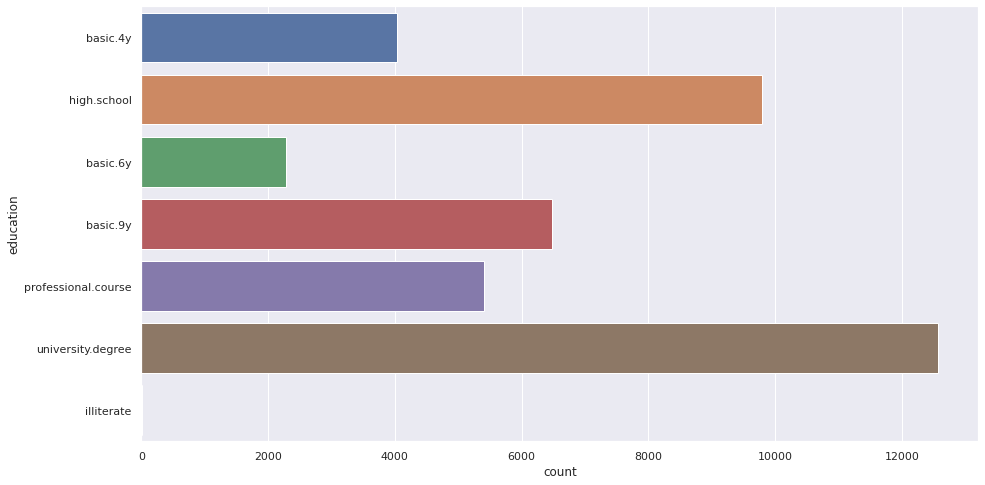

In [ ]:
col_info(df, 'education')
df.shape

**We still have the gaps. Probably after checking job feature we could clean it up.**
______________________

##3. "Job" attribute:

admin.           10411
blue-collar       9250
technician        6738
services          3967
management        2918
entrepreneur      1456
self-employed     1420
retired           1300
housemaid         1035
unemployed        1014
student            875
NaN                324
Name: job, dtype: int64
Count:  40384
Unique values: 11
NAN values in the column: 324


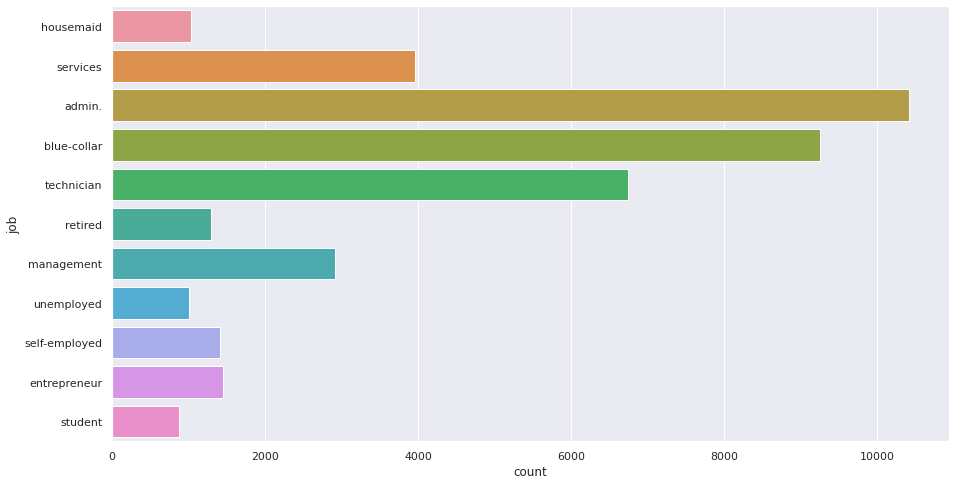

In [ ]:
col_info(df, 'job')

There are some gapes to be filled. We already know about correlation between education and job. Let's check the hitmap:

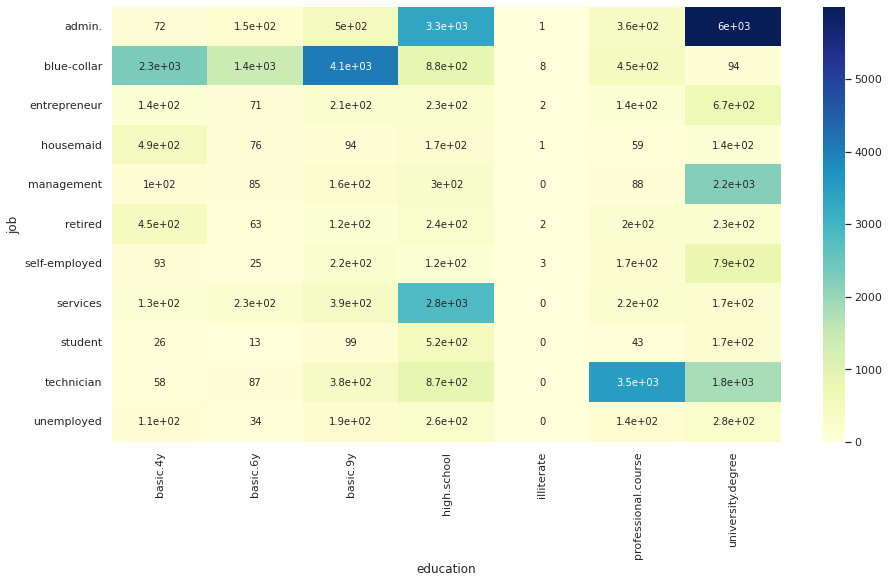

In [ ]:
sns.heatmap(pd.crosstab(df['job'], df['education']), annot=True, annot_kws={'size':10}, cmap="YlGnBu")

The heatmap shows us that "university.degree" and "high.school" can cover several values in job feature. All in all we can allocate job values based on education. Let's calculate posible weights of job position according with education:

In [ ]:
admin_undeg = df.loc[(df['job'] == "admin.")&(df['education']=="university.degree"), 'job'].count()
mngm_undeg = df.loc[(df['job'] == "management")&(df['education']=="university.degree"), 'job'].count()
tech_undeg = df.loc[(df['job'] == "technician")&(df['education']=="university.degree"), 'job'].count()
admin_hschool = df.loc[(df['job'] == "admin.")&(df['education']=="high.school"), 'job'].count()
srv_hschool = df.loc[(df['job'] == "services")&(df['education']=="high.school"), 'job'].count()

Now we can fill out the gaps:

In [ ]:
value=""
df.loc[(df['job'].isnull())&(df['education']=='university.degree'), 'job'] = value.join(random.choices(['admin.', 'management', 'technician'], weights=[admin_undeg, mngm_undeg, tech_undeg]))
df.loc[(df['job'].isnull())&(df['education']=='high.school'), 'job'] = value.join(random.choices(['admin.', 'services'], weights=[admin_hschool, srv_hschool]))
df.loc[(df['job'].isnull())&((df['education']=='basic.4y')|(df['education']=='basic.6y')|(df['education']=='basic.9y')), 'job'] = "blue-collar"
df.loc[(df['job'].isnull())&(df['education']=='professional.course'), 'job'] = "technician"

Let's check our gaps:

admin.           10411
blue-collar       9355
technician        6795
services          4004
management        2918
entrepreneur      1456
self-employed     1420
retired           1300
housemaid         1035
unemployed        1014
student            875
NaN                125
Name: job, dtype: int64
Count:  40583
Unique values: 11
NAN values in the column: 125


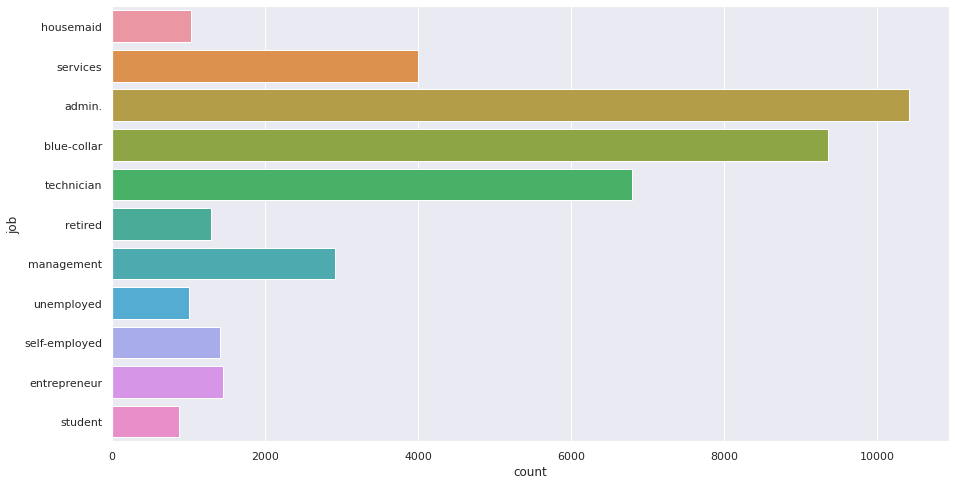

In [ ]:
col_info(df, 'job')

Now we have got gaps remain. Since the gaps also have NAN in education, probably the best way is to remove it.

In [ ]:
df = df.query("job == job")

university.degree      12576
high.school             9795
basic.9y                6472
professional.course     5409
basic.4y                4036
basic.6y                2278
illiterate                17
Name: education, dtype: int64
Count:  40583
Unique values: 7
NAN values in the column: 0


(40583, 21)

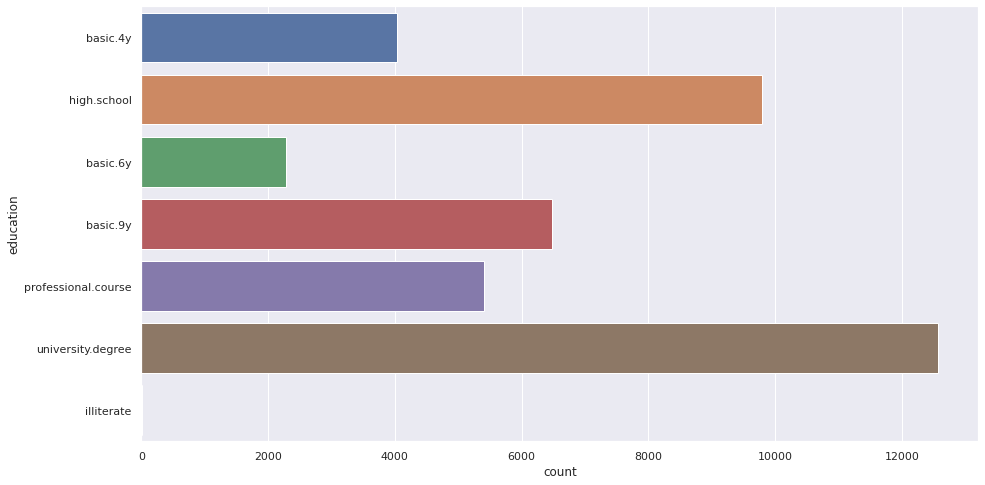

In [ ]:
col_info(df, 'education')
df.shape

**Now we heave no any gaps in job as well as in education features.**
______________________

##4. "Default" attribute:

no     32099
NaN     8481
yes        3
Name: default, dtype: int64
Count:  32102
Unique values: 2
NAN values in the column: 8481


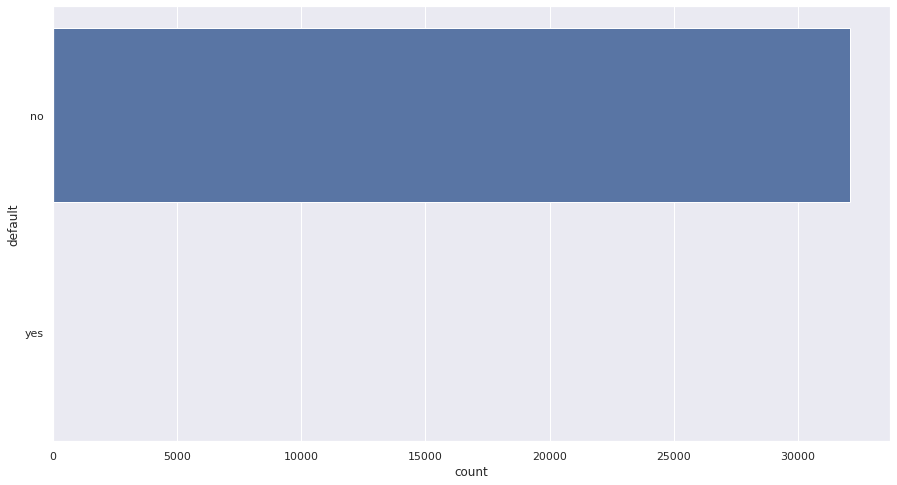

In [ ]:
col_info(df, "default")

There is a lot of gaps, but as we can see "no" value dominates so it is posible to fill gaps with mode:

no     40580
yes        3
Name: default, dtype: int64
Count:  40583
Unique values: 2
NAN values in the column: 0


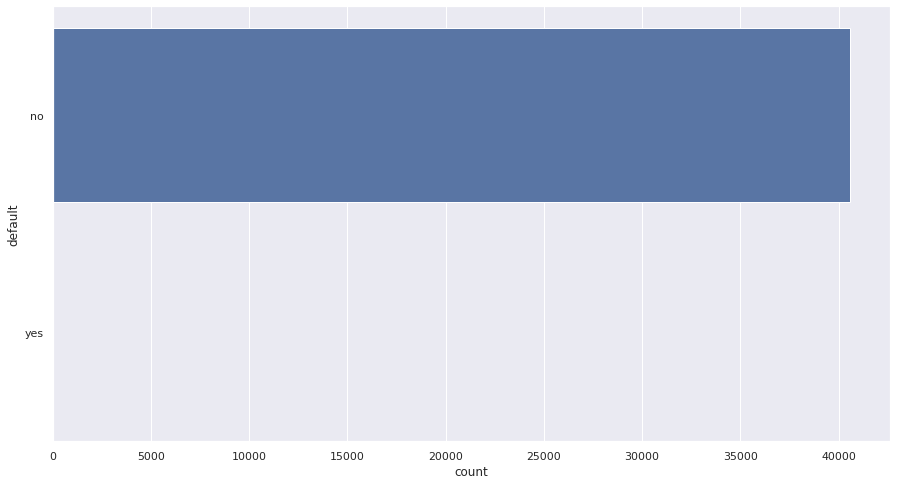

In [ ]:
#df.default = df.default.interpolate(method='pad')
df.default = nan_fill(df, "default", df.default.mode()[0])
col_info(df, "default")

As we can see binary values it would be better to transform it into [1, 0]:

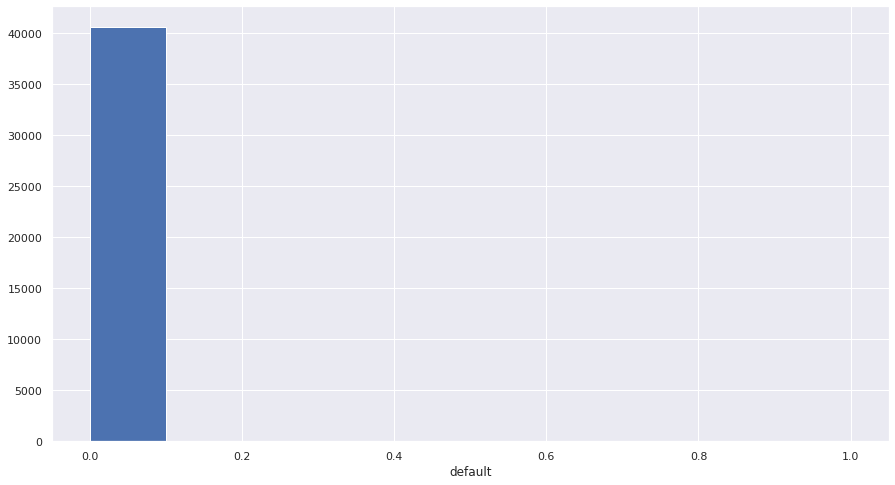

Count:  40583
Median:  0.0
Mean:  7.392257841953528e-05
Variance:  7.391893529799403e-05
Standart deviation:  0.008597612185833579
Max value:  1
Min value:  0
NAN values in the column:  0


(40583, 21)

In [ ]:
df["default"] = np.where(df.default == "no", 0, 1)
col_info(df, "default")
df.shape

**Now it looks good.**
______________________

##5. "Housing" attribute:

yes    21243
no     18361
NaN      979
Name: housing, dtype: int64
Count:  39604
Unique values: 2
NAN values in the column: 979


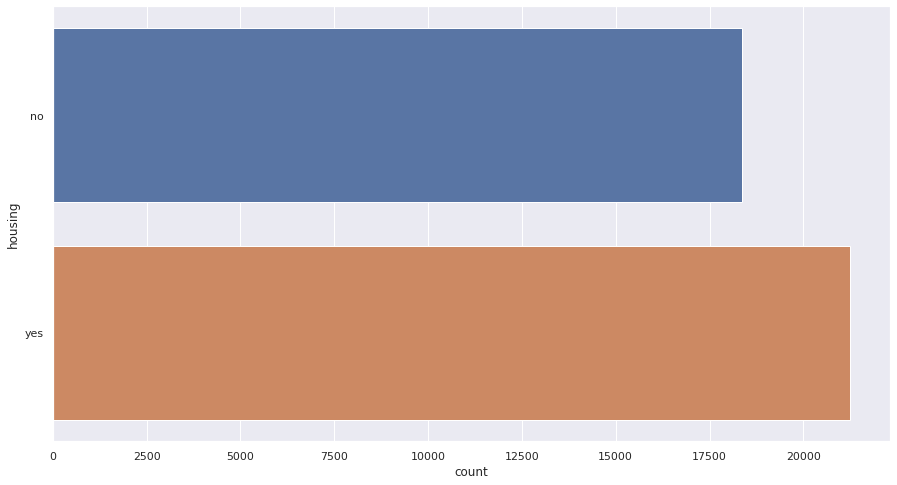

In [ ]:
col_info(df, "housing")

The chart depicts we cannot use the mode to fill the gap, however we could use the interpolation method:

yes    21737
no     18846
Name: housing, dtype: int64
Count:  40583
Unique values: 2
NAN values in the column: 0


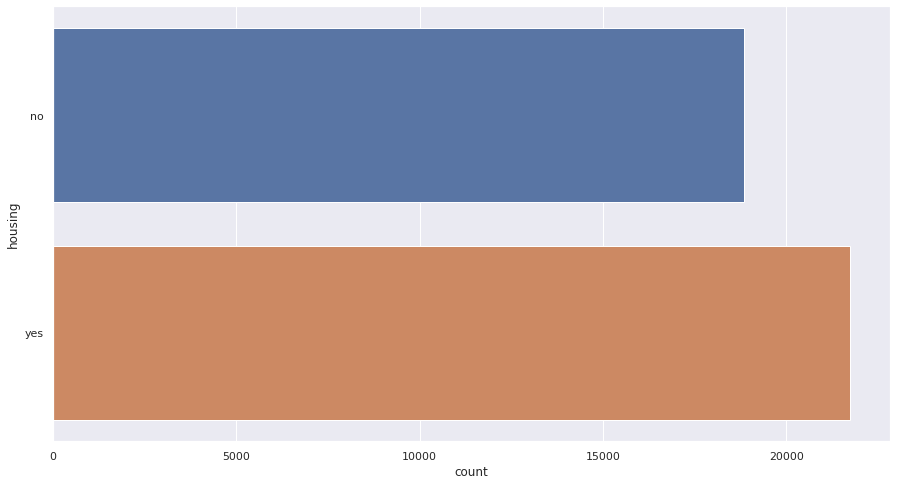

In [ ]:
df.housing = df.housing.interpolate(method='pad')
col_info(df, "housing")

As we can see binary values it would be better to transform it into [1, 0]:

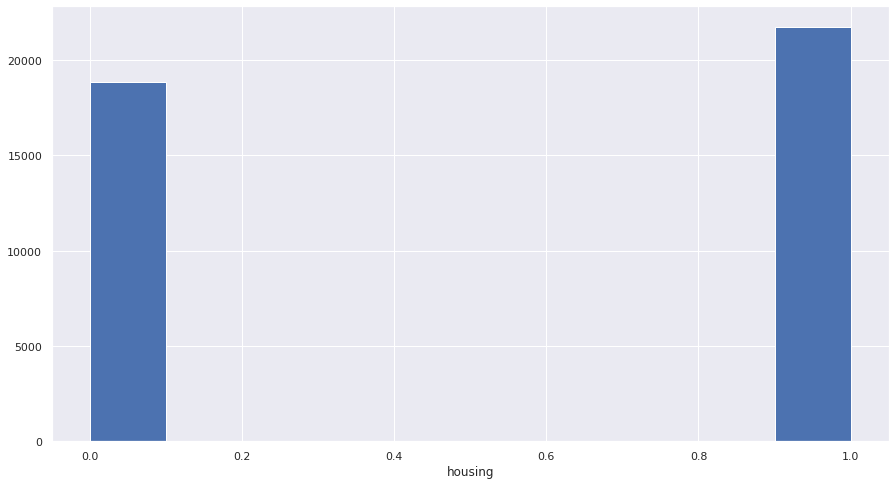

Count:  40583
Median:  1.0
Mean:  0.5356183623684794
Variance:  0.24873746136710895
Standart deviation:  0.49873586332557734
Max value:  1
Min value:  0
NAN values in the column:  0


(40583, 21)

In [ ]:
df["housing"] = np.where(df.housing == "no", 0, 1)
col_info(df, "housing")
df.shape

**Now it looks good.**
______________________

##6. "Loan" attribute:

no     33443
yes     6161
NaN      979
Name: loan, dtype: int64
Count:  39604
Unique values: 2
NAN values in the column: 979


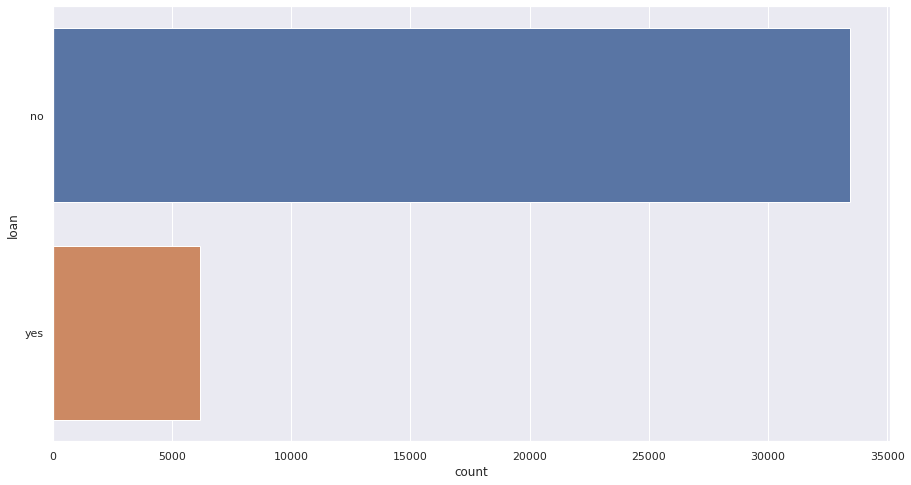

In [ ]:
col_info(df, "loan")

There are some gaps, but we probably could fill gaps with mode:

no     34422
yes     6161
Name: loan, dtype: int64
Count:  40583
Unique values: 2
NAN values in the column: 0


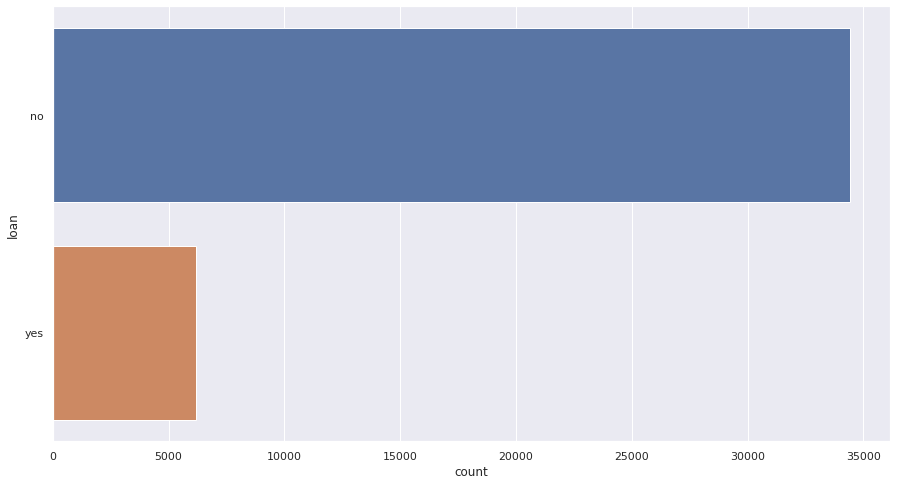

In [ ]:
df.loan = nan_fill(df, "loan", df.loan.mode()[0])
col_info(df, "loan")

As we can see binary values it would be better to transform it into [1, 0]:

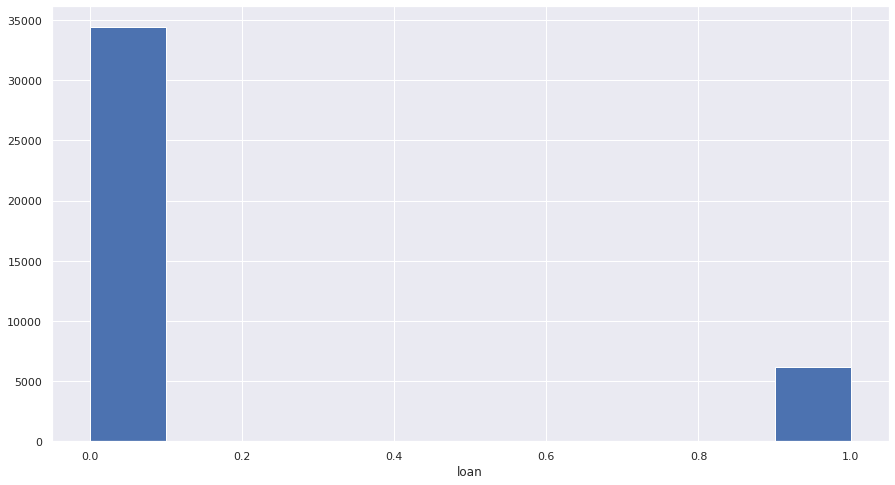

Count:  40583
Median:  0.0
Mean:  0.15181233521425228
Variance:  0.128768523058075
Standart deviation:  0.3588433126840669
Max value:  1
Min value:  0
NAN values in the column:  0


(40583, 21)

In [ ]:
df["loan"] = np.where(df.loan == "no", 0, 1)
col_info(df, "loan")
df.shape

**Now it looks good.**
______________________

##7. "Contact" attribute:

cellular     25649
telephone    14934
Name: contact, dtype: int64
Count:  40583
Unique values: 2
NAN values in the column: 0


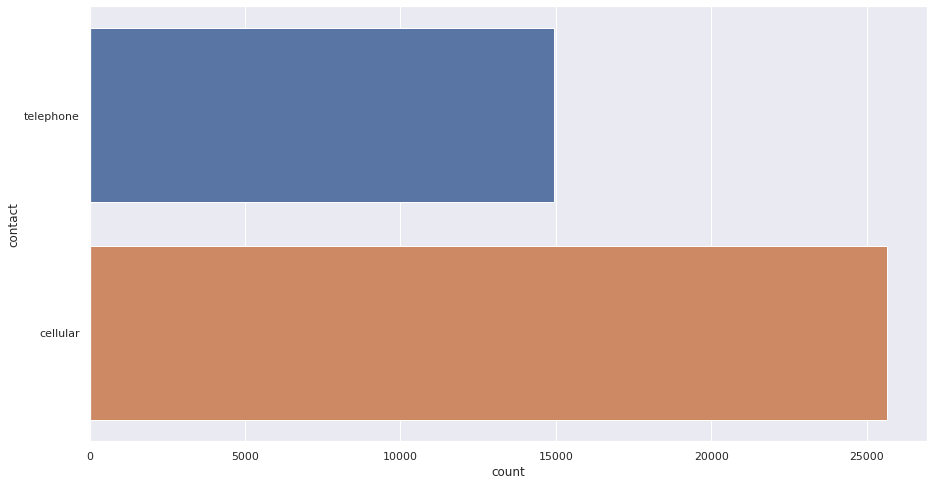

In [ ]:
col_info(df, "contact")

There are binary values, but we cannot simply transform to [1,0]. Let's proceed considering this feature in the way: is contact has cellular - 1, 0 - contact has no cellular (prefers telephone):

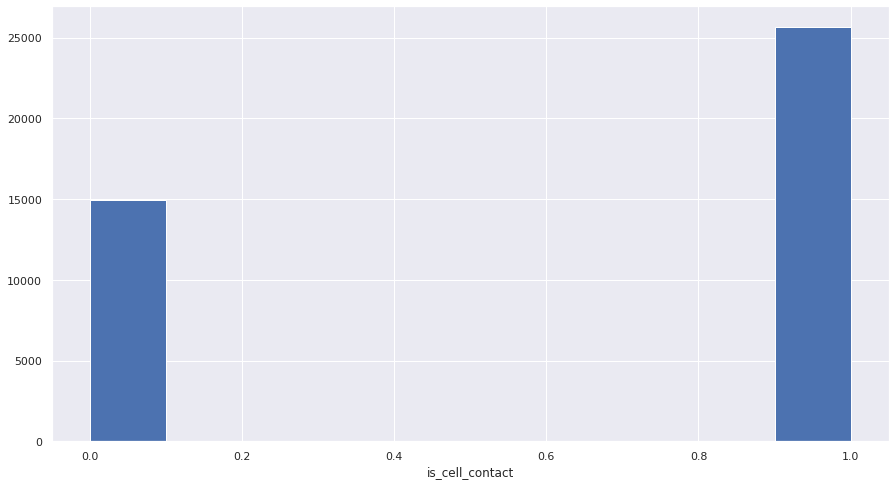

Count:  40583
Median:  1.0
Mean:  0.6320134046275534
Variance:  0.2325781919252436
Standart deviation:  0.48226361248309374
Max value:  1
Min value:  0
NAN values in the column:  0


(40583, 21)

In [ ]:
df.rename(columns={'contact': 'is_cell_contact'}, inplace=True)
df["is_cell_contact"] = np.where(df.is_cell_contact == "cellular", 1, 0)
col_info(df, "is_cell_contact")
df.shape

**Now it looks good.**
______________________

##8. "Month" attribute:

may    13696
jul     7114
aug     6056
jun     5279
nov     4061
apr     2559
oct      646
sep      510
mar      503
dec      159
Name: month, dtype: int64
Count:  40583
Unique values: 10
NAN values in the column: 0


(40583, 21)

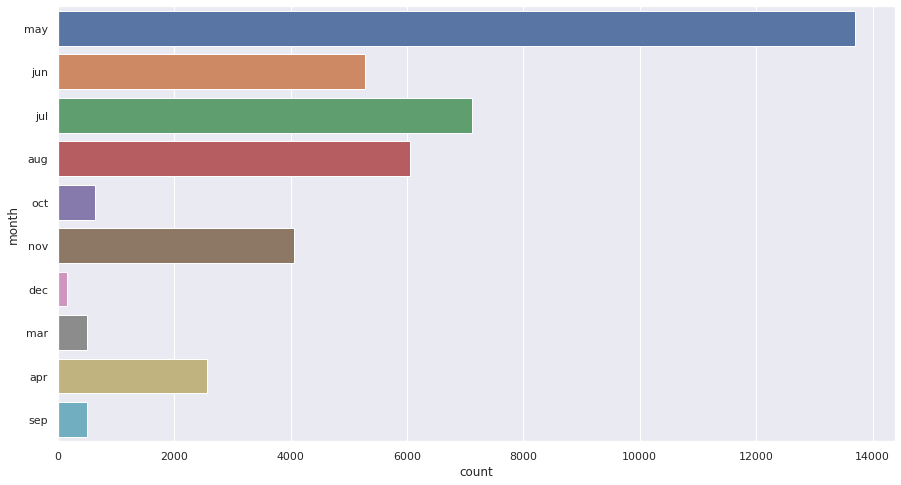

In [ ]:
col_info(df, "month")
df.shape

**In general almost half of the all contacts happend in may.**
______________________

##9. "Day_of_week" attribute:

thu    8488
mon    8393
wed    8029
tue    7954
fri    7719
Name: day_of_week, dtype: int64
Count:  40583
Unique values: 5
NAN values in the column: 0


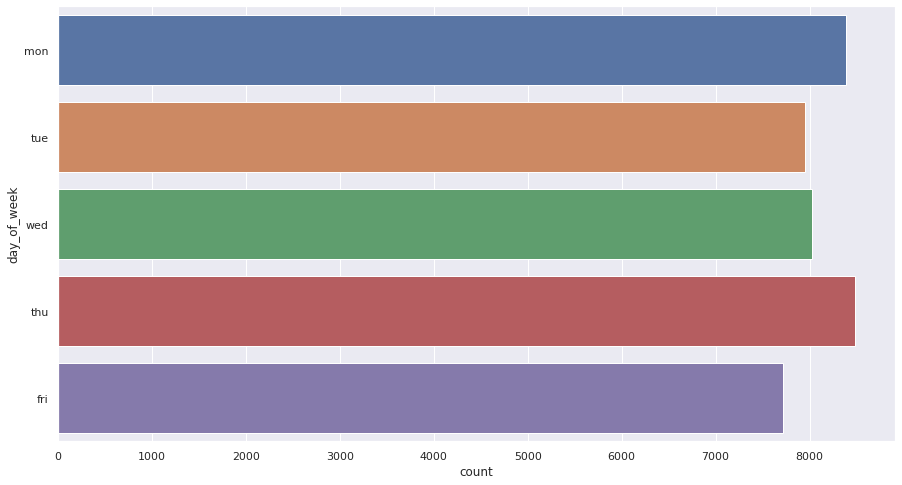

In [ ]:
col_info(df, "day_of_week")

Let's replace categorical values with numerical values:

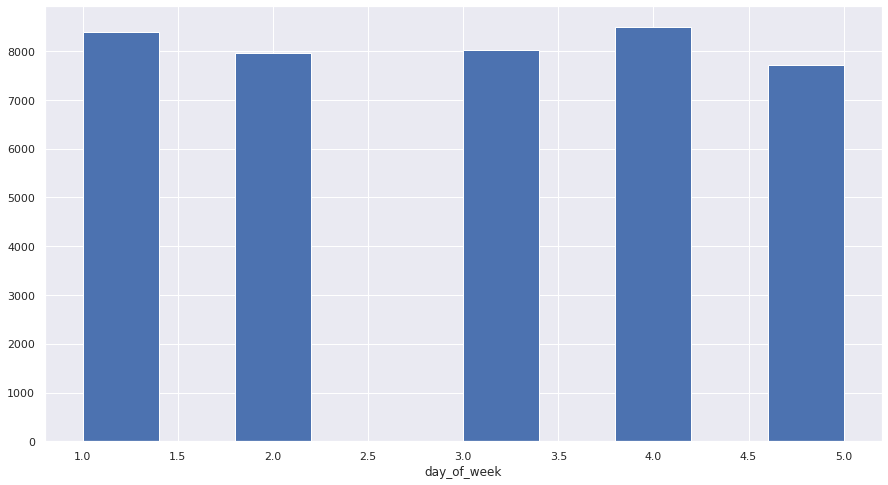

Count:  40583
Median:  3.0
Mean:  2.9799423403888325
Variance:  1.9928459185135121
Standart deviation:  1.4116819466556594
Max value:  5
Min value:  1
NAN values in the column:  0


(40583, 21)

In [ ]:
day = {"mon": 1, 
      "tue": 2,
      "wed": 3,
      "thu": 4,
      "fri": 5
     }
df["day_of_week"].replace(day, inplace=True)
col_info(df, "day_of_week")
df.shape

**Now it looks good.**
______________________

##10. "Duration" attribute:

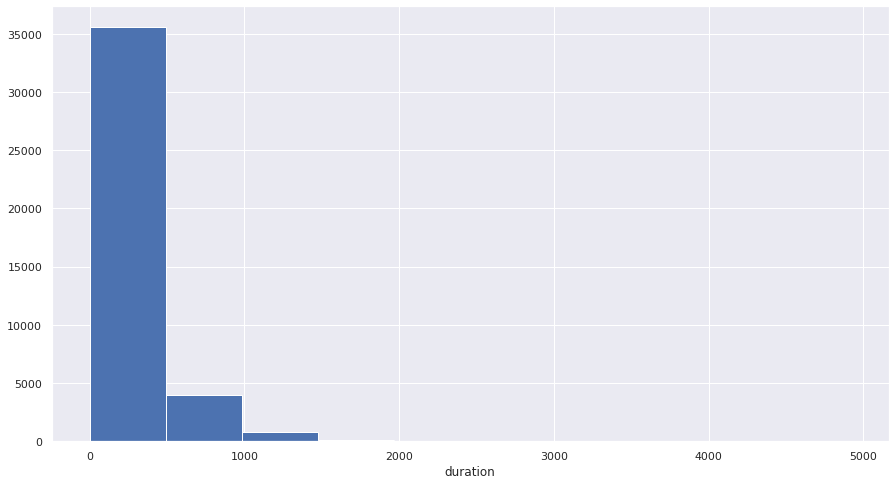

Count:  40583
Median:  179.0
Mean:  258.285686124732
Variance:  67469.06736373385
Standart deviation:  259.748084427458
Max value:  4918
Min value:  0
NAN values in the column:  0


In [ ]:
col_info(df, "duration")

As it's known that feature highly affects the target. That's way we have to delete it from main dataset.

In [ ]:
del df['duration']


______________________

##11. "Campaign" attribute:

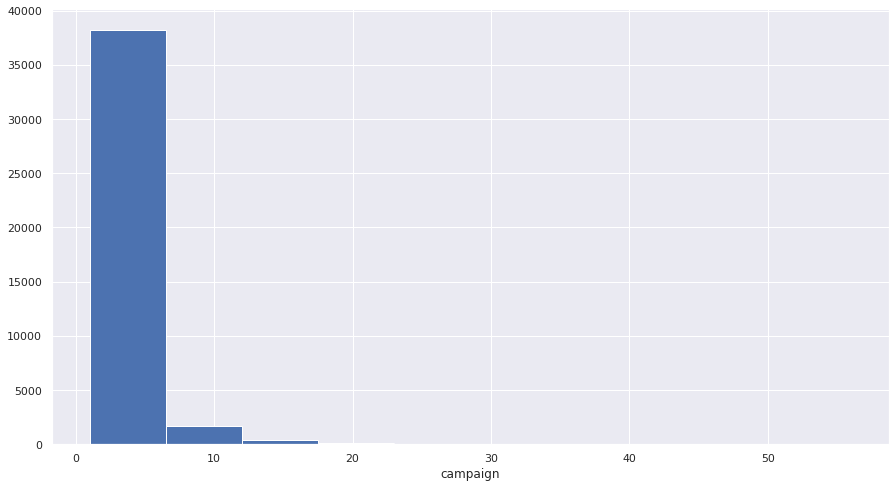

Count:  40583
Median:  2.0
Mean:  2.573713131114013
Variance:  7.716505770249739
Standart deviation:  2.7778599263191333
Max value:  56
Min value:  1
NAN values in the column:  0


(40583, 20)

In [ ]:
col_info(df, "campaign")
df.shape

**Now it looks good.**
______________________

##12. "Pdays" attribute:

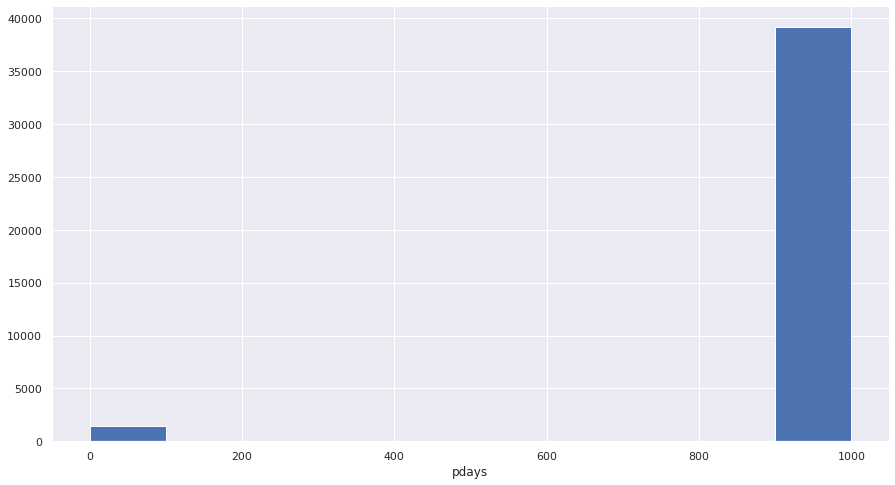

Count:  40583
Median:  999.0
Mean:  964.501589335436
Variance:  33066.136850021896
Standart deviation:  181.8409658190967
Max value:  999
Min value:  0
NAN values in the column:  0


In [ ]:
col_info(df, "pdays")

The current distribution looks suspicious especially the right tail. Let's look at value counts:

In [ ]:
df.pdays.value_counts()

999    39173
3        398
6        378
4        110
9         60
2         60
12        56
7         55
10        51
5         45
13        34
11        28
1         26
15        22
14        18
8         16
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: pdays, dtype: int64

It seems as that 999 value should be turned to 0:

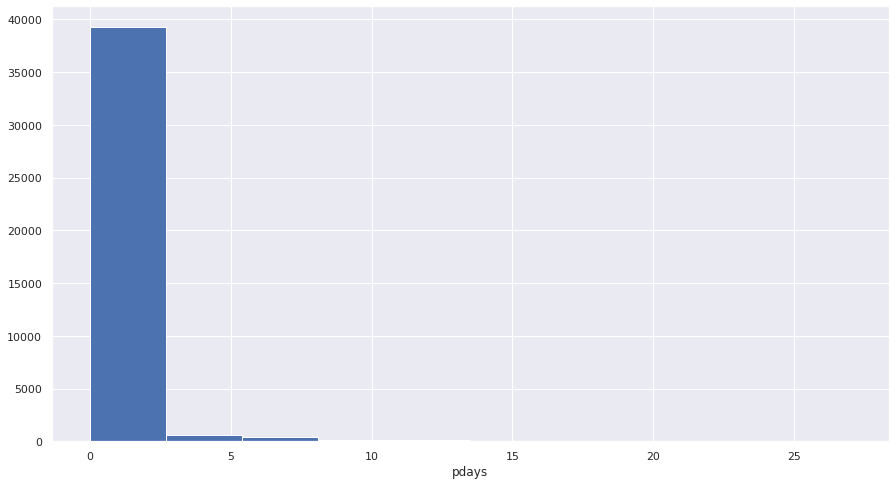

Count:  40583
Median:  0.0
Mean:  0.21045758076041693
Variance:  1.7530304519916415
Standart deviation:  1.3240205632812663
Max value:  27
Min value:  0
NAN values in the column:  0


(40583, 20)

In [ ]:
df.loc[df.pdays == 999, "pdays"] = 0
col_info(df, "pdays")
df.shape

**Now it looks good.**
______________________

##13. "Previous" attribute:

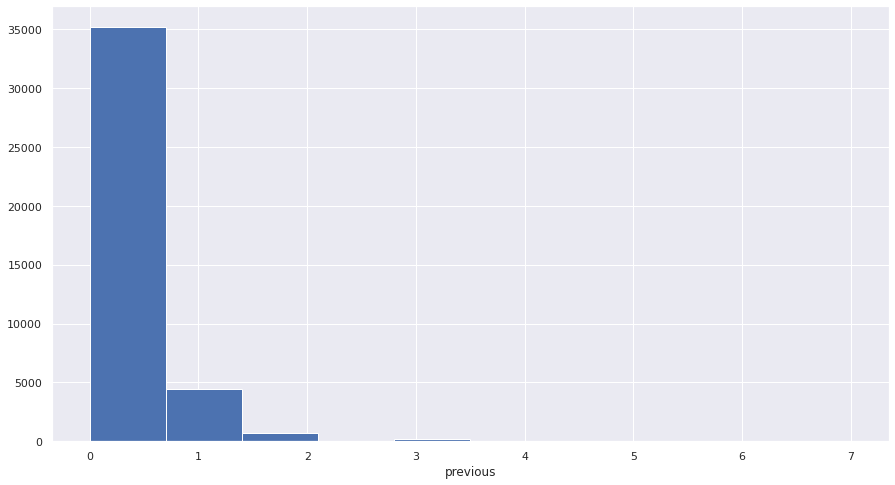

Count:  40583
Median:  0.0
Mean:  0.16726215410393513
Variance:  0.23386290714954067
Standart deviation:  0.48359374184282067
Max value:  7
Min value:  0
NAN values in the column:  0


(40583, 20)

In [ ]:
col_info(df, "previous")
df.shape

**Now it looks good.**
______________________

##14. "Poutcome" attribute:

nonexistent    35170
failure         4137
success         1276
Name: poutcome, dtype: int64
Count:  40583
Unique values: 3
NAN values in the column: 0


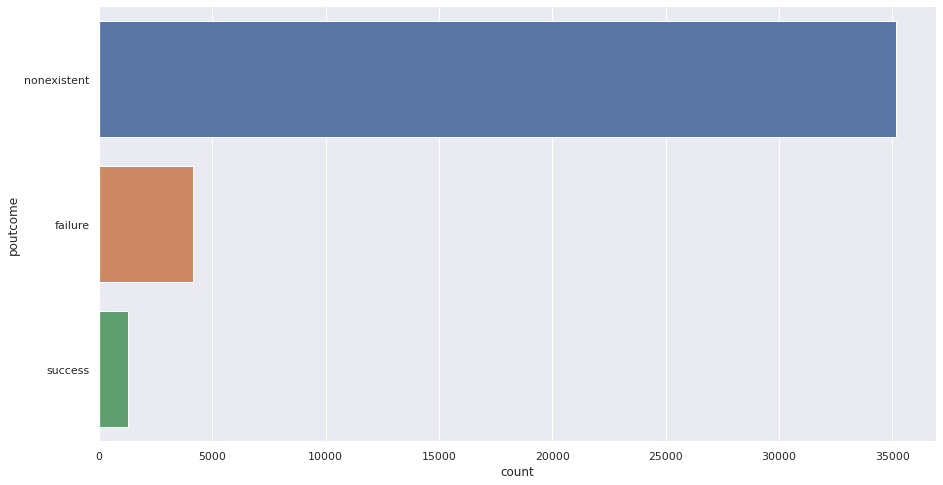

In [ ]:
col_info(df, "poutcome")

Let's replace categorical values with numerical values. We could consider success and failure as 1 and 0.5. If a value is non of them then we could put 0.

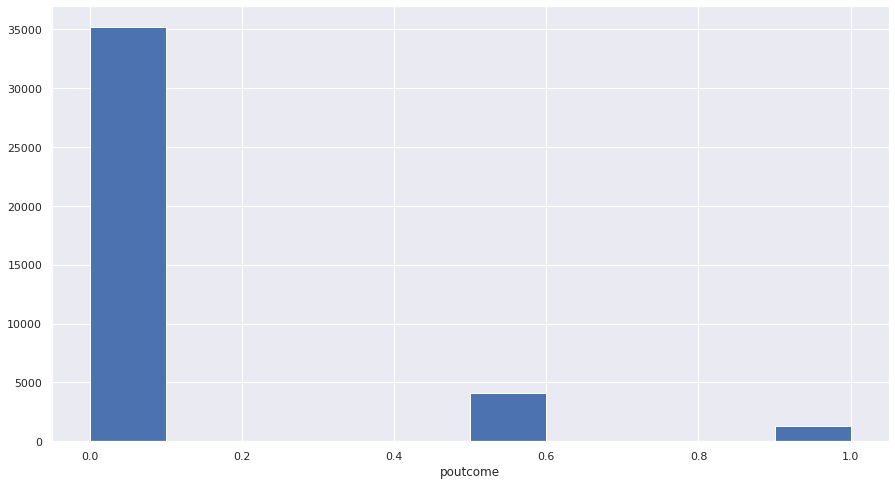

Count:  40583
Median:  0.0
Mean:  0.08241135450804524
Variance:  0.050136149643874556
Standart deviation:  0.22391103064358966
Max value:  1.0
Min value:  0.0
NAN values in the column:  0


(40583, 20)

In [ ]:
pout = {"nonexistent": 0, 
      "failure": 0.5,
      "success": 1
     }
df["poutcome"].replace(pout, inplace=True)
col_info(df, "poutcome")
df.shape

**Now it looks good.**
______________________

##15. "Emp.var.rate" attribute:

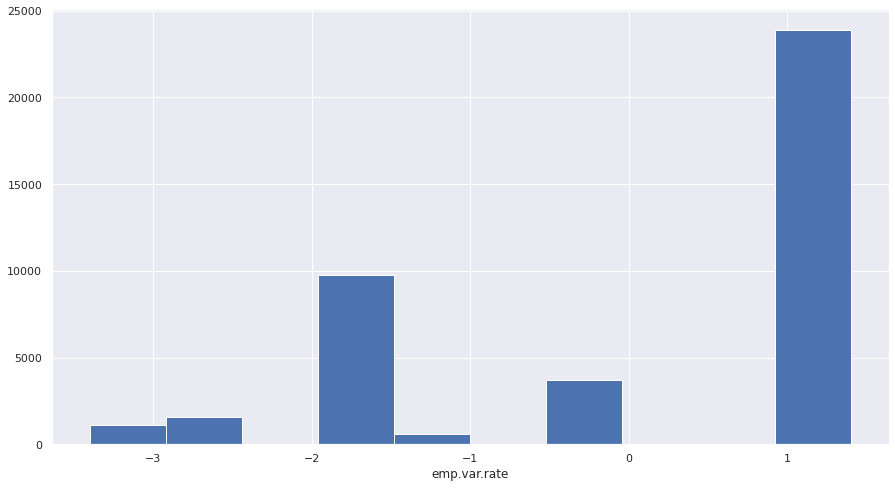

Count:  40583
Median:  1.1
Mean:  0.10798363846996804
Variance:  2.420180703295944
Standart deviation:  1.5556929977652865
Max value:  1.4
Min value:  -3.4
NAN values in the column:  0


In [ ]:
col_info(df, "emp.var.rate")

Probably it would be better to shift values to the right:

In [ ]:
df["emp.var.rate"] = df["emp.var.rate"] + 3.4

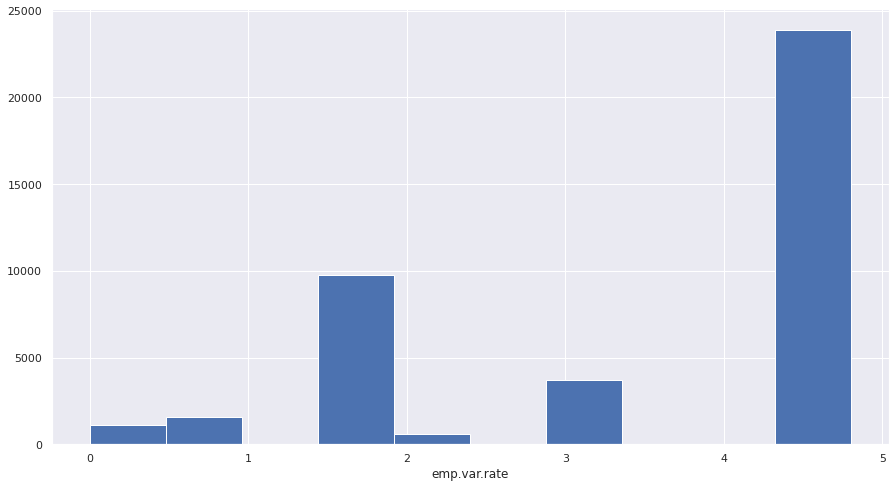

Count:  40583
Median:  4.5
Mean:  3.5079836384720378
Variance:  2.4201807032954803
Standart deviation:  1.5556929977651375
Max value:  4.8
Min value:  0.0
NAN values in the column:  0


(40583, 20)

In [ ]:
col_info(df, "emp.var.rate")
df.shape

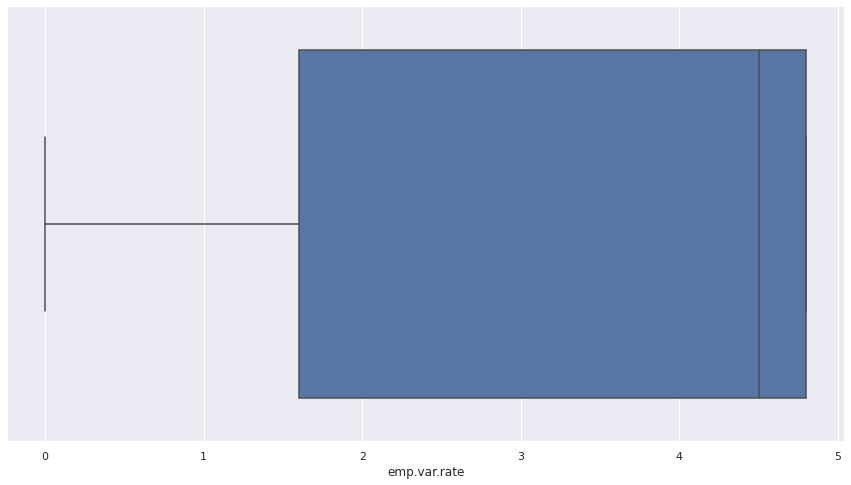

In [ ]:
sns.boxplot(x="emp.var.rate", data=df)

**Now it looks good.**
______________________

##16. "Cons.price.idx" attribute:

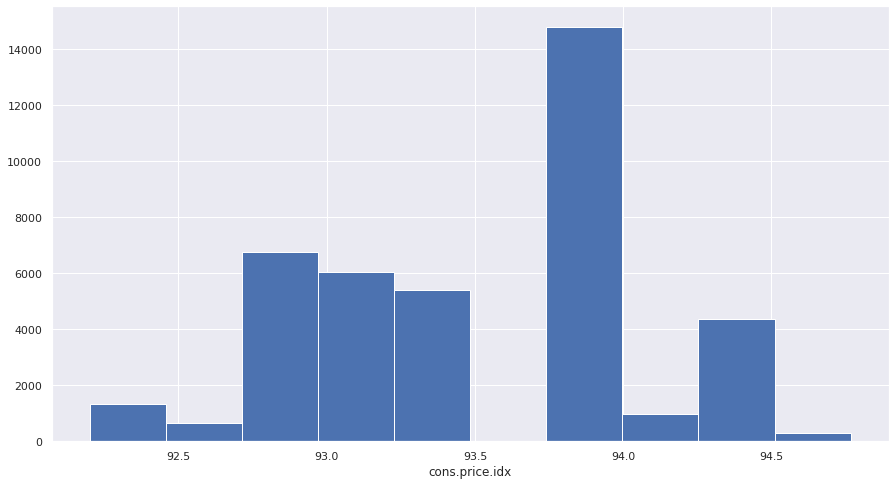

Count:  40583
Median:  93.749
Mean:  93.58033410546383
Variance:  0.3297411112036752
Standart deviation:  0.5742308866681374
Max value:  94.767
Min value:  92.201
NAN values in the column:  0


(40583, 20)

In [ ]:
col_info(df, "cons.price.idx")
df.shape

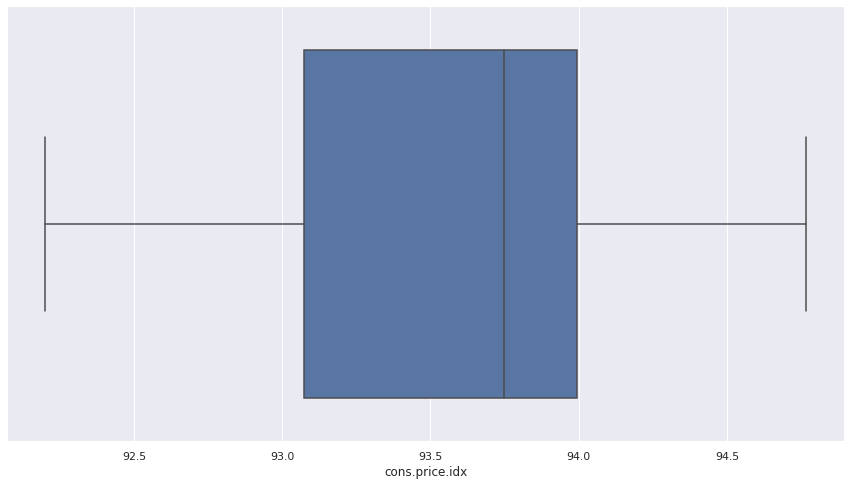

In [ ]:
sns.boxplot(x="cons.price.idx", data=df)

**It looks like nothing should be applied**
______________________

##17. "Cons.conf.idx" attribute:

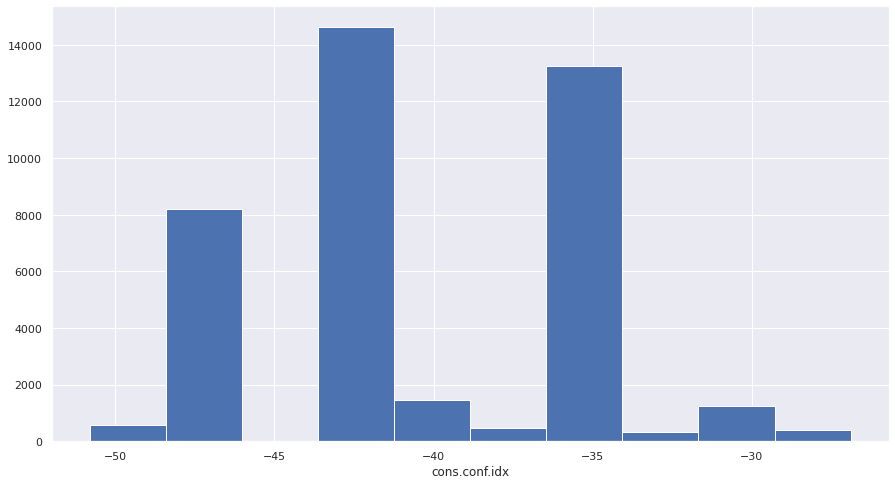

Count:  40583
Median:  -41.8
Mean:  -40.55471256436424
Variance:  20.88019457449303
Standart deviation:  4.569485154204249
Max value:  -26.9
Min value:  -50.8
NAN values in the column:  0


In [ ]:
col_info(df, "cons.conf.idx")

In [ ]:
df["cons.conf.idx"] = df["cons.conf.idx"] + 50.8

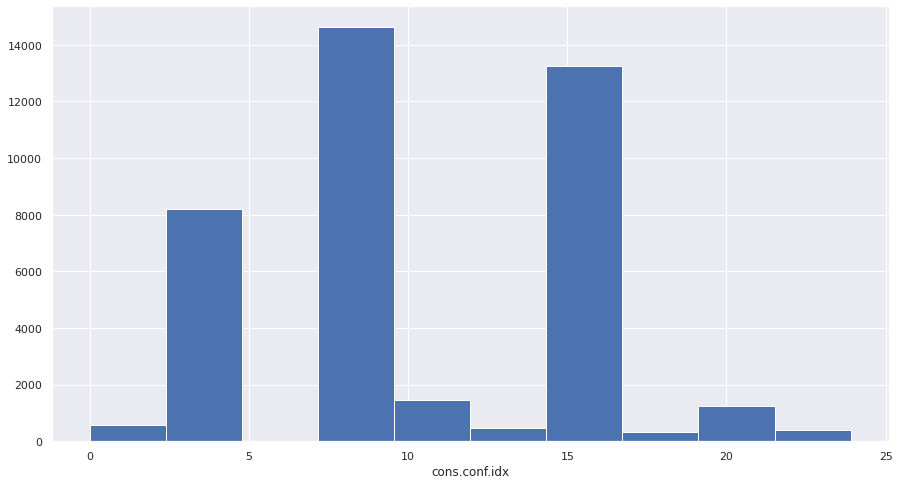

Count:  40583
Median:  9.0
Mean:  10.245287435624736
Variance:  20.880194574497516
Standart deviation:  4.56948515420474
Max value:  23.9
Min value:  0.0
NAN values in the column:  0


(40583, 20)

In [ ]:
col_info(df, "cons.conf.idx")
df.shape

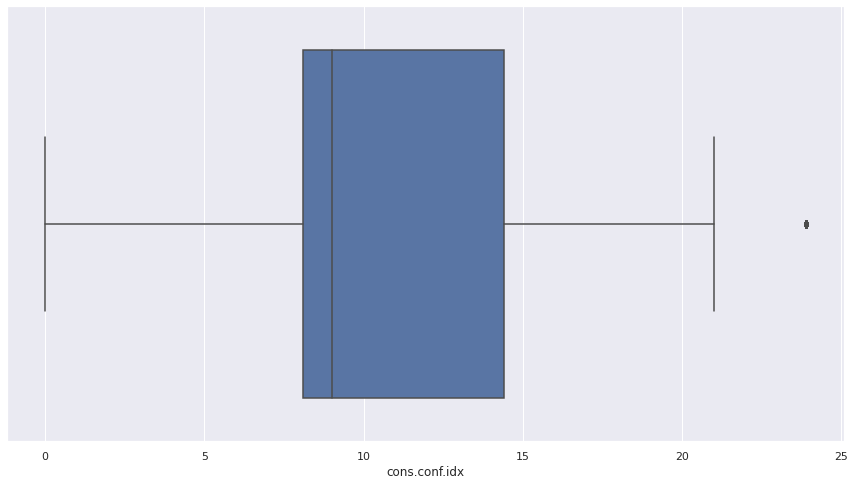

In [ ]:
sns.boxplot(x="cons.conf.idx", data=df)

Looks like there are outliers, let's use IQR analysis:

25-percentile: 8.099999999999994, 75-percentile: 14.399999999999999, IQR: 6.300000000000004, outlier range: [-1.350000000000012, 23.850000000000005]


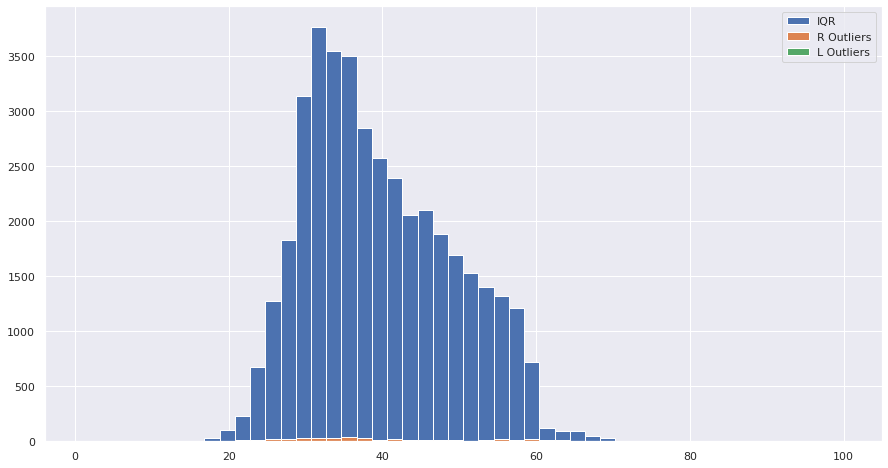

In [ ]:
perc25 = df["cons.conf.idx"].quantile(0.25)
perc75 = df["cons.conf.idx"].quantile(0.75)
IQR = perc75 - perc25
left = perc25 - 1.5 * IQR
right = perc75 + 1.5 * IQR
print(f"25-percentile: {perc25}, 75-percentile: {perc75}, IQR: {IQR}, outlier range: [{left}, {right}]")
df.age.loc[df["cons.conf.idx"].between(left, right)].hist(bins=50, range= (1, 100), label='IQR')
df.age.loc[df["cons.conf.idx"] >= right].hist(alpha = 1, bins=50, range= (1, 100), label='R Outliers')
df.age.loc[df["cons.conf.idx"] <= left].hist(alpha = 1, bins=50, range= (1, 100), label='L Outliers')
plt.legend()
plt.show()

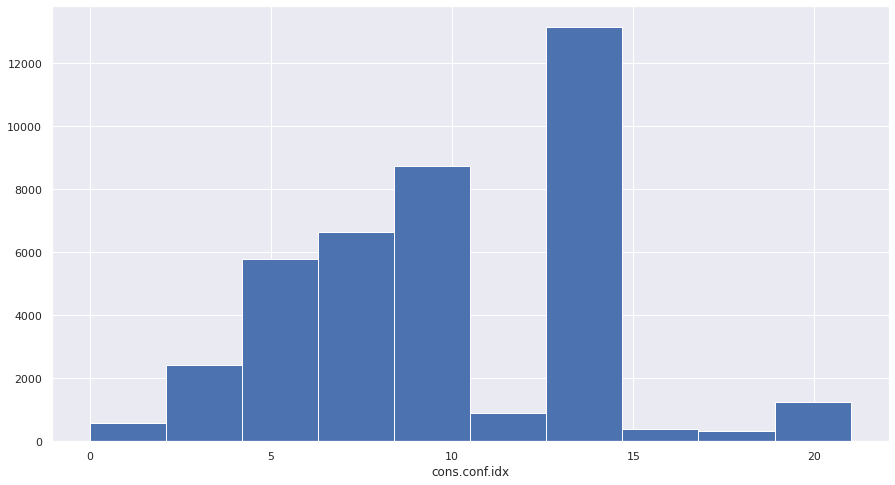

Count:  40192
Median:  9.0
Mean:  10.112450238852249
Variance:  19.251783481390266
Standart deviation:  4.387685435556002
Max value:  20.999999999999996
Min value:  0.0
NAN values in the column:  0


(40192, 20)

In [ ]:
df = df.loc[~df["cons.conf.idx"].isin(df["cons.conf.idx"].loc[df["cons.conf.idx"] >= right])]
col_info(df, "cons.conf.idx")
df.shape

##18. "Euribor3m" attribute:

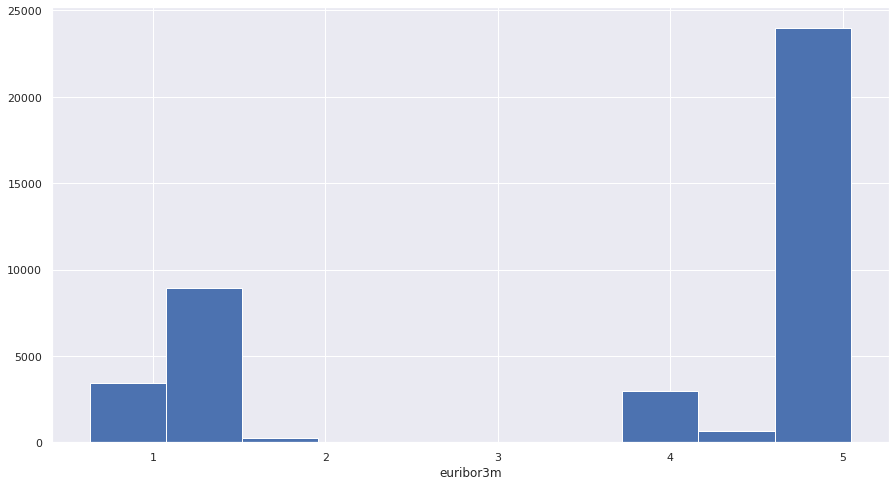

Count:  40192
Median:  4.857
Mean:  3.678726711783377
Variance:  2.9030819224748035
Standart deviation:  1.7038432799042298
Max value:  5.045
Min value:  0.634
NAN values in the column:  0


(40192, 20)

In [ ]:
col_info(df, "euribor3m")
df.shape

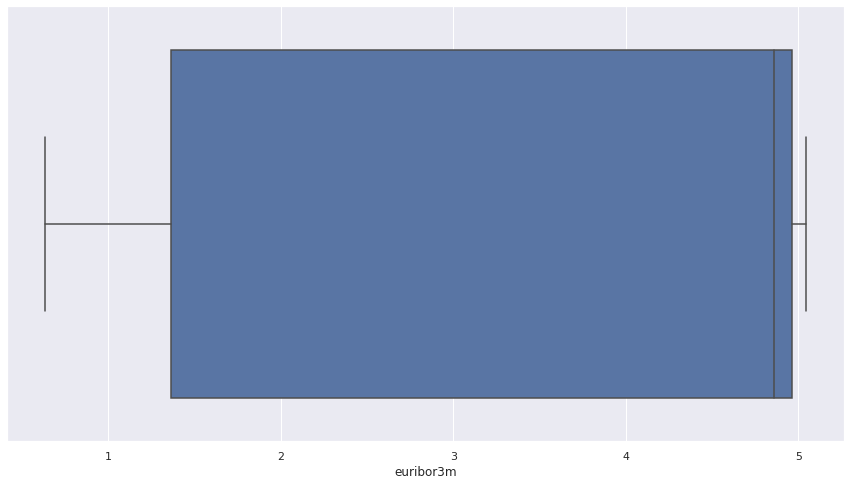

In [ ]:
sns.boxplot(x="euribor3m", data=df)

**It looks like nothing should be applied**
______________________

##19. "Nr.employed" attribute:

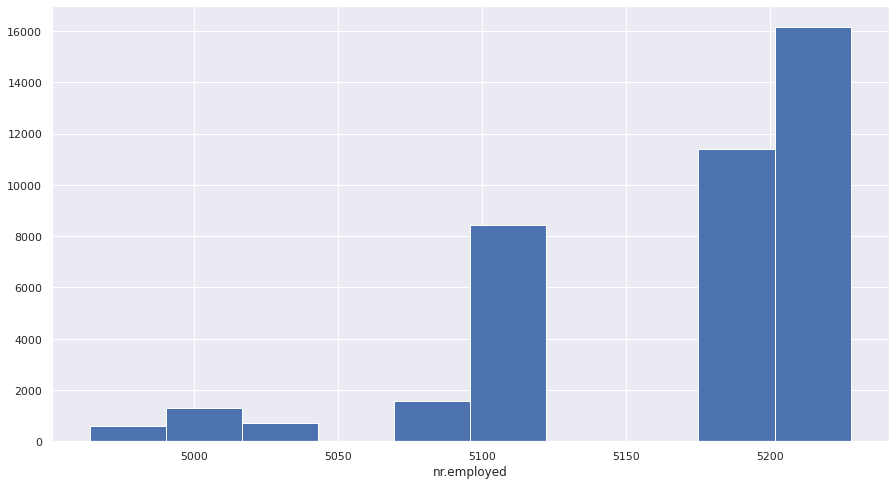

Count:  40192
Median:  5191.0
Mean:  5170.004635247677
Variance:  4868.4689613719
Standart deviation:  69.7744148049405
Max value:  5228.1
Min value:  4963.6
NAN values in the column:  0


(40192, 20)

In [ ]:
col_info(df, "nr.employed")
df.shape

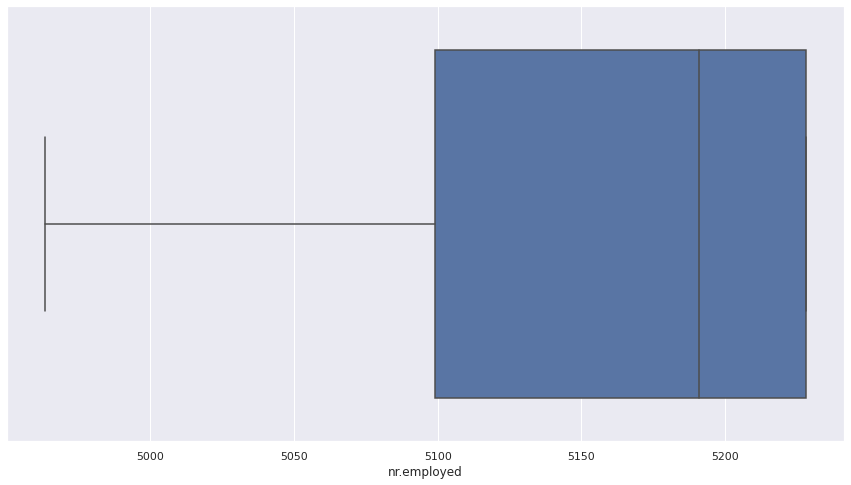

In [ ]:
sns.boxplot(x="nr.employed", data=df)

**It looks like nothing should be applied**
______________________

##20. "Marital" attribute:

married     24269
single      11401
divorced     4449
NaN            73
Name: marital, dtype: int64
Count:  40119
Unique values: 3
NAN values in the column: 73


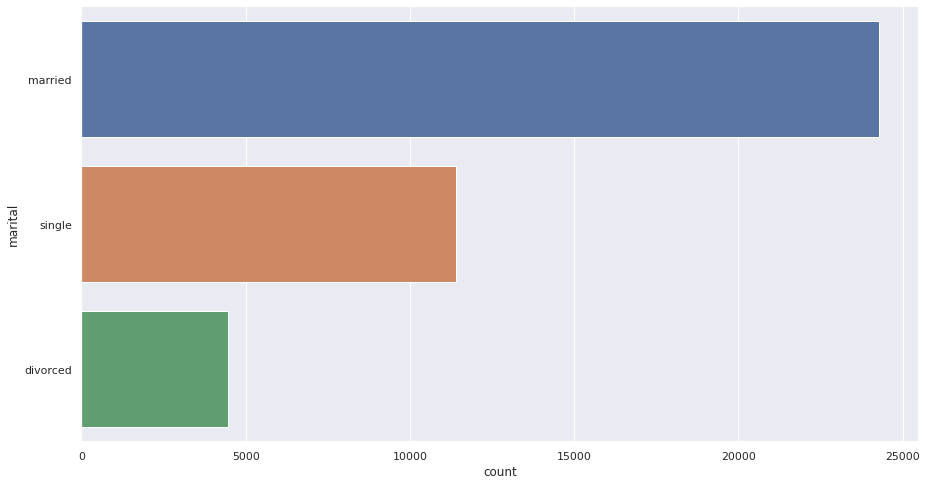

In [ ]:
col_info(df, "marital")

A better way to fill out gaps is interpolation. Let's fill gaps:

married     24313
single      11418
divorced     4461
Name: marital, dtype: int64
Count:  40192
Unique values: 3
NAN values in the column: 0


(40192, 20)

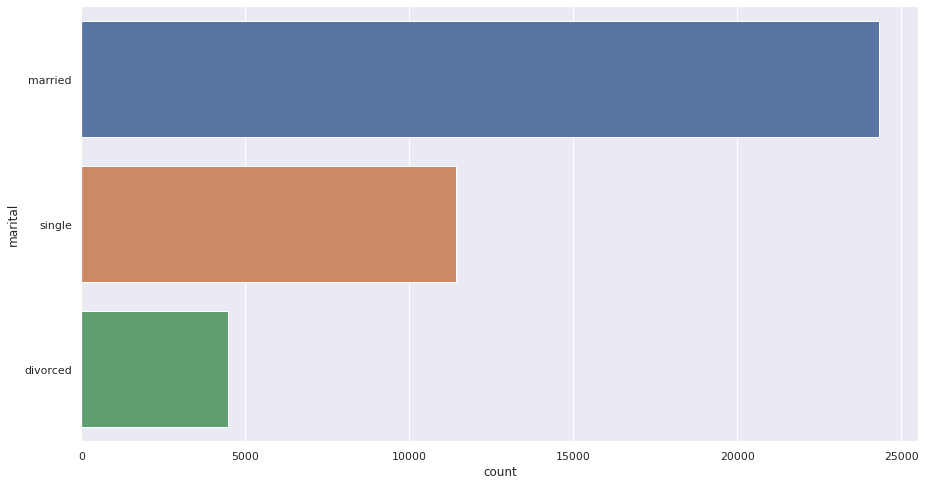

In [ ]:
df.marital = df.marital.interpolate(method='pad')
col_info(df, "marital")
df.shape

##21. "Y" attribute:

Let's take a look at target value:

no     35945
yes     4247
Name: y, dtype: int64
Count:  40192
Unique values: 2
NAN values in the column: 0


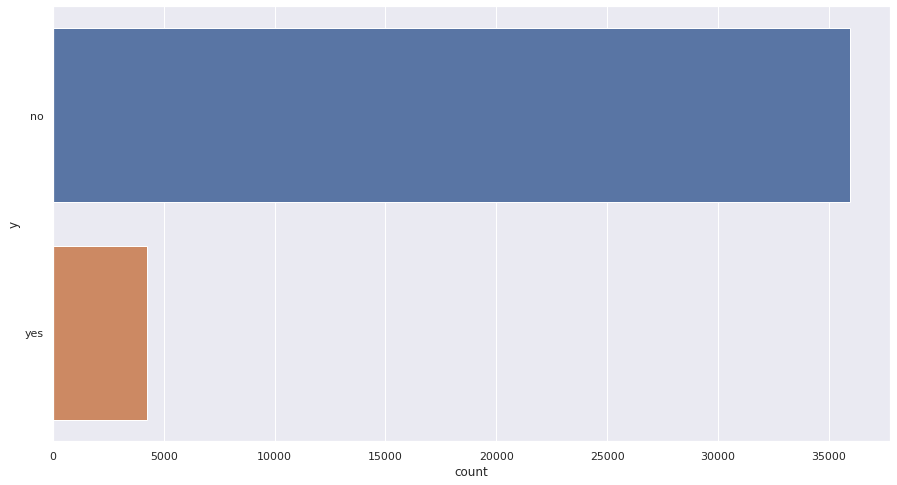

In [ ]:
col_info(df, "y")

For the correlation anlysis let's transform categorial values into numeric:

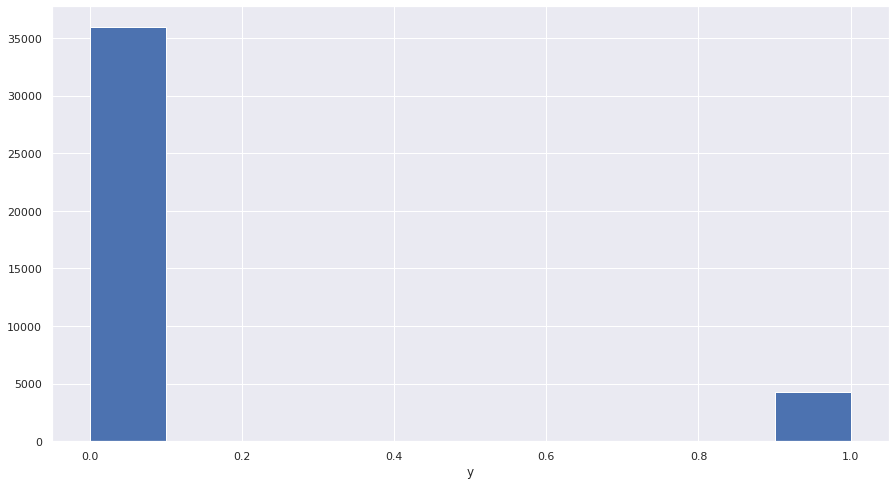

Count:  40192
Median:  0.0
Mean:  0.10566779458598727
Variance:  0.09450446309850345
Standart deviation:  0.30741578212333776
Max value:  1
Min value:  0
NAN values in the column:  0


(40192, 20)

In [ ]:
df["y"] = np.where(df.y == "no", 0, 1)
col_info(df, "y")
df.shape

**Now it looks good.**
______________________

In [ ]:
#sns.pairplot(df)

______________________

#Feature engineering part 1

Since we need fulfilling correlation analysis, have to transform categorical features:

Let's transform education:

In [ ]:
df = pd.get_dummies(df, columns = ["education"])
education = list(df.columns.values)
flt = filter(lambda x: x.startswith("education"), education)
education = list(flt)
df[education]

,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree
0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...
41181,0,0,0,0,0,0,1
41182,1,0,0,0,0,0,0
41184,0,0,0,0,0,1,0
41185,0,0,0,0,0,0,1


Let's transform job:

In [ ]:
df = pd.get_dummies(df, columns = ["job"])
job = list(df.columns.values)
flt = filter(lambda x: x.startswith("job"), job)
job = list(flt)
df[job]

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
41181,1,0,0,0,0,0,0,0,0,0,0
41182,0,0,0,0,0,0,0,0,0,0,1
41184,0,1,0,0,0,0,0,0,0,0,0
41185,0,0,0,0,0,1,0,0,0,0,0


Let's transform month:

In [ ]:
df = pd.get_dummies(df, columns = ["month"])
month = list(df.columns.values)
flt = filter(lambda x: x.startswith("month"), month)
month = list(flt)
df[month]

,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
41181,0,0,0,0,0,0,0,1,0,0
41182,0,0,0,0,0,0,0,1,0,0
41184,0,0,0,0,0,0,0,1,0,0
41185,0,0,0,0,0,0,0,1,0,0


Let's transform marital:

In [ ]:
df = pd.get_dummies(df, columns = ["marital"])
marital = list(df.columns.values)
flt = filter(lambda x: x.startswith("marital"), marital)
marital = list(flt)
df[marital]

,marital_divorced,marital_married,marital_single
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
41181,0,1,0
41182,0,0,1
41184,0,1,0
41185,0,1,0


In [ ]:
df

,age,default,housing,loan,is_cell_contact,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,marital_divorced,marital_married,marital_single
0,56,0,0,0,0,1,1,0,0,0.0,4.5,93.994,14.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,57,0,0,0,0,1,1,0,0,0.0,4.5,93.994,14.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,37,0,1,0,0,1,1,0,0,0.0,4.5,93.994,14.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,40,0,0,0,0,1,1,0,0,0.0,4.5,93.994,14.4,4.857,5191.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
4,56,0,0,1,0,1,1,0,0,0.0,4.5,93.994,14.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41181,37,0,1,0,1,5,1,0,0,0.0,2.3,94.767,0.0,1.028,4963.6,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
41182,29,0,1,0,1,5,1,9,1,1.0,2.3,94.767,0.0,1.028,4963.6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
41184,46,0,0,0,1,5,1,0,0,0.0,2.3,94.767,0.0,1.028,4963.6,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
41185,56,0,1,0,1,5,2,0,0,0.0,2.3,94.767,0.0,1.028,4963.6,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
df.shape

(40192, 47)

______________________

#Correlation analysis

Let's take a look at correlation matrix. First of all let's check numerical features:

In [ ]:
numerical = df[["age", 
           "campaign", 
           "pdays", 
           "default",
           "housing",
           "loan",
           "is_cell_contact",
           "day_of_week",
           "previous", 
           "emp.var.rate", 
           "cons.price.idx", 
           "cons.conf.idx", 
           "euribor3m", 
           "nr.employed",
           "y"]]
numerical.corr()

,age,campaign,pdays,default,housing,loan,is_cell_contact,day_of_week,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,0.015430,-0.012648,0.002493,-0.004276,-0.005894,-0.033078,-0.019352,-0.023581,0.075139,0.039649,0.104187,0.086729,0.072081,-0.019550
campaign,0.015430,1.000000,-0.039436,-0.003876,-0.011627,0.004377,-0.074645,0.015501,-0.076832,0.144153,0.122044,0.000538,0.128748,0.138007,-0.061108
pdays,-0.012648,-0.039436,1.000000,-0.001343,0.004056,-0.003108,0.093789,-0.007828,0.476821,-0.213235,-0.033478,0.047597,-0.246419,-0.321286,0.259232
default,0.002493,-0.003876,-0.001343,1.000000,-0.003505,-0.003660,0.006625,-0.005984,0.003050,0.004296,-0.003495,0.005161,0.005143,0.005861,-0.002970
housing,-0.004276,-0.011627,0.004056,-0.003505,1.000000,0.046459,0.084731,-0.009970,0.025008,-0.063234,-0.086102,-0.035626,-0.061078,-0.047055,0.011859
loan,-0.005894,0.004377,-0.003108,-0.003660,0.046459,1.000000,0.013682,0.001296,-0.001702,-0.000696,-0.007818,-0.011555,-0.002087,0.002033,-0.003416
is_cell_contact,-0.033078,-0.074645,0.093789,0.006625,0.084731,0.013682,1.000000,-0.021078,0.211090,-0.391858,-0.600299,-0.291589,-0.396347,-0.261605,0.138052
day_of_week,-0.019352,0.015501,-0.007828,-0.005984,-0.009970,0.001296,-0.021078,1.000000,0.002307,-0.000783,-0.000782,-0.005880,-0.003200,0.002155,0.007030
previous,-0.023581,-0.076832,0.476821,0.003050,0.025008,-0.001702,0.211090,0.002307,1.000000,-0.422830,-0.204010,-0.088226,-0.454850,-0.502959,0.220569
emp.var.rate,0.075139,0.144153,-0.213235,0.004296,-0.063234,-0.000696,-0.391858,-0.000783,-0.422830,1.000000,0.767288,0.314171,0.973279,0.903856,-0.279398


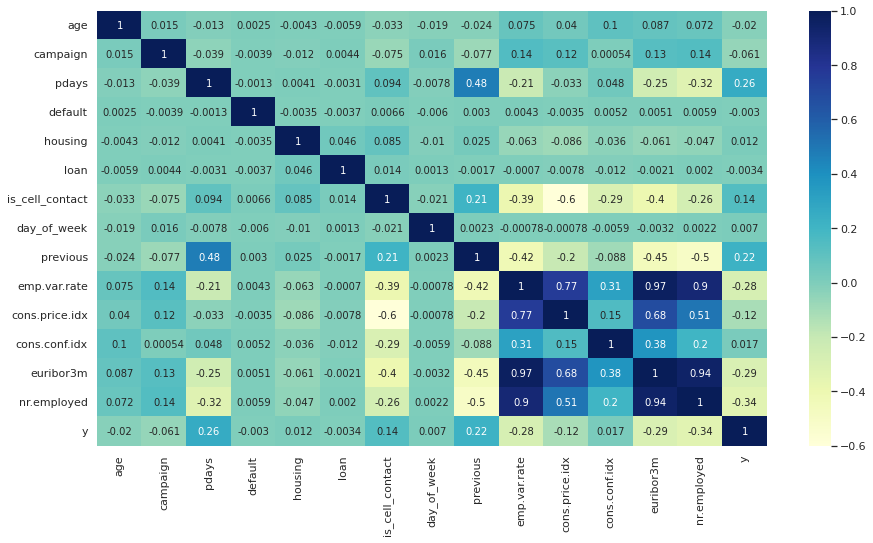

In [ ]:
sns.heatmap(numerical.corr(), annot=True, annot_kws={'size':10}, cmap="YlGnBu")

The matrix depicts:
- very high positive correlation between "emp.var.rate" and "euribor3m" (0.97)
- very high positive correlation between "emp.var.rate" and "nr.employed" (0.9)
- high positive correlation between "emp.var.rate" and "cons.price.idx" (0.77)
- high positive correlation between "euribor3m" and "cons.price.idx" (0.68)
- medium positive correlation between "nr.employed" and "cons.price.idx" (0.51)
- medium negative correlation between "nr.employed" and "previous" (-0.5)
- medium negative correlation between "cons.price.idx" and "is_cell_contact" (-0.6)

The high correlated features will lead to multicollinearity, so we need to rid of those or fulfil dimensionality reduction.

Moreover took a look at the target we can see sufficient correlations with pdays (0.26), previous (0.22), emp.var.rate (-0.29), euribor3m (-0.3) and nr.employed (-0.34). 

Now we could check categorical features:

In [ ]:
categorical = df[education + job + month + marital]
categorical.corr()

,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,marital_divorced,marital_married,marital_single
education_basic.4y,1.000000,-0.081182,-0.145190,-0.187493,-0.006837,-0.130179,-0.222311,-0.181456,0.283112,-0.003988,0.203420,-0.060683,0.144759,-0.021352,-0.073602,-0.033830,-0.137612,0.005955,-0.009721,-0.021938,-0.003729,0.006829,0.026552,-0.017973,0.028523,-0.034191,-0.004571,-0.017625,-0.010783,0.122183,-0.124937
education_basic.6y,-0.081182,1.000000,-0.106706,-0.137796,-0.005025,-0.095674,-0.163386,-0.106450,0.233983,-0.006068,0.012477,-0.032654,-0.005573,-0.031908,0.000526,-0.028402,-0.084615,-0.015267,-0.007552,-0.061245,-0.015394,0.010308,0.012708,-0.017789,0.060315,-0.024946,-0.015440,-0.012262,-0.025831,0.084577,-0.073690
education_basic.9y,-0.145190,-0.106706,1.000000,-0.246442,-0.008986,-0.171108,-0.292208,-0.179049,0.418216,-0.008333,-0.030283,-0.078416,-0.032324,-0.002197,-0.057419,-0.019901,-0.126394,0.009042,0.001085,-0.107785,-0.011324,0.026112,0.011849,-0.023555,0.086880,-0.026060,-0.021240,-0.035588,-0.019411,0.073211,-0.065842
education_high.school,-0.187493,-0.137796,-0.246442,1.000000,-0.011605,-0.220963,-0.377346,0.107847,-0.189663,-0.035993,-0.027534,-0.089435,-0.024155,-0.070594,0.367988,0.122357,-0.117807,0.004130,0.008386,-0.074276,-0.001283,0.028115,0.003712,-0.010686,0.035029,-0.013001,0.015699,-0.001102,0.022033,-0.080461,0.071874
education_illiterate,-0.006837,-0.005025,-0.008986,-0.011605,1.000000,-0.008057,-0.013760,-0.009295,0.011628,0.009015,0.004343,-0.005712,0.010180,0.015808,-0.006827,-0.003024,-0.009220,-0.003276,0.004548,0.004866,-0.001296,0.006312,-0.007999,-0.002316,-0.007131,0.005148,-0.001644,-0.002332,0.000436,0.009199,-0.010275
education_professional.course,-0.130179,-0.095674,-0.171108,-0.220963,-0.008057,1.000000,-0.261997,-0.169520,-0.137682,-0.024174,-0.036917,-0.084033,0.010622,-0.008580,-0.077063,-0.035676,0.512466,0.004617,-0.007915,0.069734,0.000993,-0.015980,-0.009364,0.011267,-0.035666,-0.000525,0.004690,0.014508,0.020207,-0.005831,-0.007754
education_university.degree,-0.222311,-0.163386,-0.292208,-0.377346,-0.013760,-0.261997,1.000000,0.337862,-0.355763,0.062917,-0.061497,0.262659,-0.051204,0.102462,-0.190847,-0.035080,-0.035412,-0.010491,0.007050,0.147640,0.019599,-0.044865,-0.029141,0.040931,-0.123436,0.067469,0.009612,0.036245,0.000006,-0.101049,0.109535
job_admin.,-0.181456,-0.106450,-0.179049,0.107847,-0.009295,-0.169520,0.337862,1.000000,-0.322428,-0.113374,-0.094952,-0.162897,-0.105583,-0.111861,-0.194709,-0.086232,-0.262957,-0.093422,-0.002620,0.077668,0.008436,-0.001122,-0.019352,0.020106,-0.058912,0.008360,0.007688,0.016510,0.024641,-0.121070,0.114079
job_blue-collar,0.283112,0.233983,0.418216,-0.189663,0.011628,-0.137682,-0.355763,-0.322428,1.000000,-0.106212,-0.088954,-0.152607,-0.098914,-0.104795,-0.182409,-0.080785,-0.246346,-0.087520,-0.005710,-0.133616,-0.022429,0.023729,0.030773,-0.034830,0.132786,-0.065930,-0.027584,-0.052301,-0.056650,0.132958,-0.104671
job_entrepreneur,-0.003988,-0.006068,-0.008333,-0.035993,0.009015,-0.024174,0.062917,-0.113374,-0.106212,1.000000,-0.031278,-0.053660,-0.034781,-0.036849,-0.064140,-0.028406,-0.086621,-0.030774,0.009228,-0.053771,-0.010052,0.005907,0.010654,-0.019353,-0.002560,0.054415,-0.005350,-0.007590,0.007821,0.051819,-0.061619


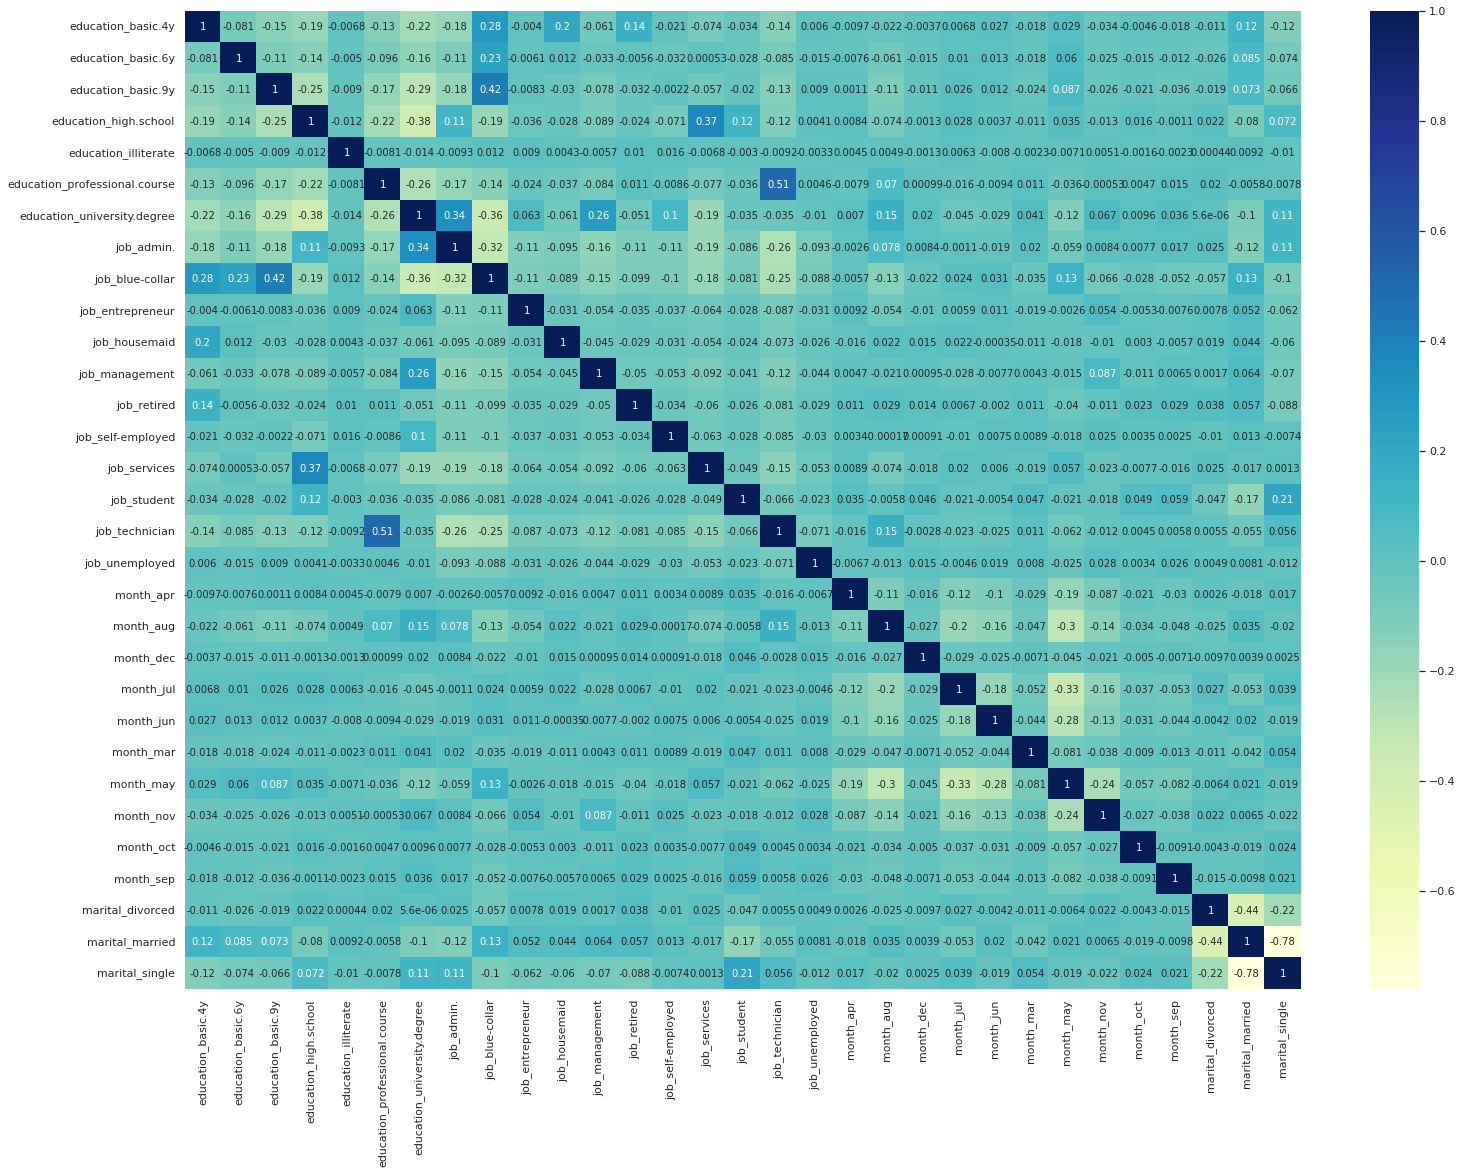

In [ ]:
sns.set(rc = {'figure.figsize':(25,18)})
sns.heatmap(categorical.corr(), annot=True, annot_kws={'size':10}, cmap="YlGnBu")

______________________

#Feature Selection

Let's check feature importance fulfilling chi-squared test:

In [ ]:
X = df.copy()
del X["y"]
y = df["y"]
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['feature', 'score']  
featureScores.sort_values(by="score", ascending=False)

,feature,score
7,pdays,2.283169e+04
14,nr.employed,4.290749e+03
8,previous,2.744856e+03
13,euribor3m,2.677462e+03
10,emp.var.rate,2.057470e+03
9,poutcome,1.613882e+03
38,month_mar,8.571249e+02
42,month_sep,6.362201e+02
6,campaign,4.514909e+02
41,month_oct,4.407111e+02


As we can see "pdays" is the most important feature. We could leave "nr.employed", "previous", "euribor3m", "emp.var.rate" and "poutcome" as well.

Let's check those with Random forest algorithm:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df.columns[:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X, y)
importances = forest.feature_importances_
importances

array([1.94471069e-01, 7.65953050e-07, 4.06435354e-02, 2.59428764e-02,
       1.54629147e-02, 6.68595228e-02, 9.62304622e-02, 3.48761054e-02,
       1.88237742e-02, 3.24237232e-02, 2.34559621e-02, 1.90689740e-02,
       2.29337216e-02, 1.34592109e-01, 4.76333399e-02, 7.18693285e-03,
       6.10310760e-03, 1.06794636e-02, 1.53106887e-02, 2.77272895e-04,
       1.12291599e-02, 1.53386441e-02, 1.66817787e-02, 1.08958092e-02,
       5.75944281e-03, 4.42106901e-03, 8.77761600e-03, 5.71044013e-03,
       6.43402376e-03, 8.95509594e-03, 5.49115281e-03, 1.36307058e-02,
       5.34762753e-03, 3.34944995e-03, 2.03891387e-03, 9.31485847e-04,
       2.18618158e-03, 2.66427303e-03, 5.05789548e-03, 4.43517899e-03,
       1.84939883e-03, 4.74343428e-03, 2.45043655e-03, 9.83082873e-03,
       1.50613344e-02, 1.37523013e-02])

In [ ]:
indices = np.argsort(importances)[::-1]
indices

array([ 0, 13,  6,  5, 14,  2,  7,  9,  3, 10, 12, 11,  8, 22,  4, 21, 18,
       44, 45, 31, 20, 23, 17, 43, 29, 26, 15, 28, 16, 24, 27, 30, 32, 38,
       41, 39, 25, 33, 37, 42, 36, 34, 40, 35, 19,  1])

In [ ]:
for f in range(X.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) age                            0.194471
 2) euribor3m                      0.134592
 3) campaign                       0.096230
 4) day_of_week                    0.066860
 5) nr.employed                    0.047633
 6) housing                        0.040644
 7) pdays                          0.034876
 8) poutcome                       0.032424
 9) loan                           0.025943
10) emp.var.rate                   0.023456
11) cons.conf.idx                  0.022934
12) cons.price.idx                 0.019069
13) previous                       0.018824
14) education_university.degree    0.016682
15) is_cell_contact                0.015463
16) education_professional.course  0.015339
17) education_basic.9y             0.015311
18) marital_divorced               0.015061
19) marital_married                0.013752
20) job_student                    0.013631
21) education_illiterate           0.011229
22) job_admin.                     0.010896
23) education_basic.6y          

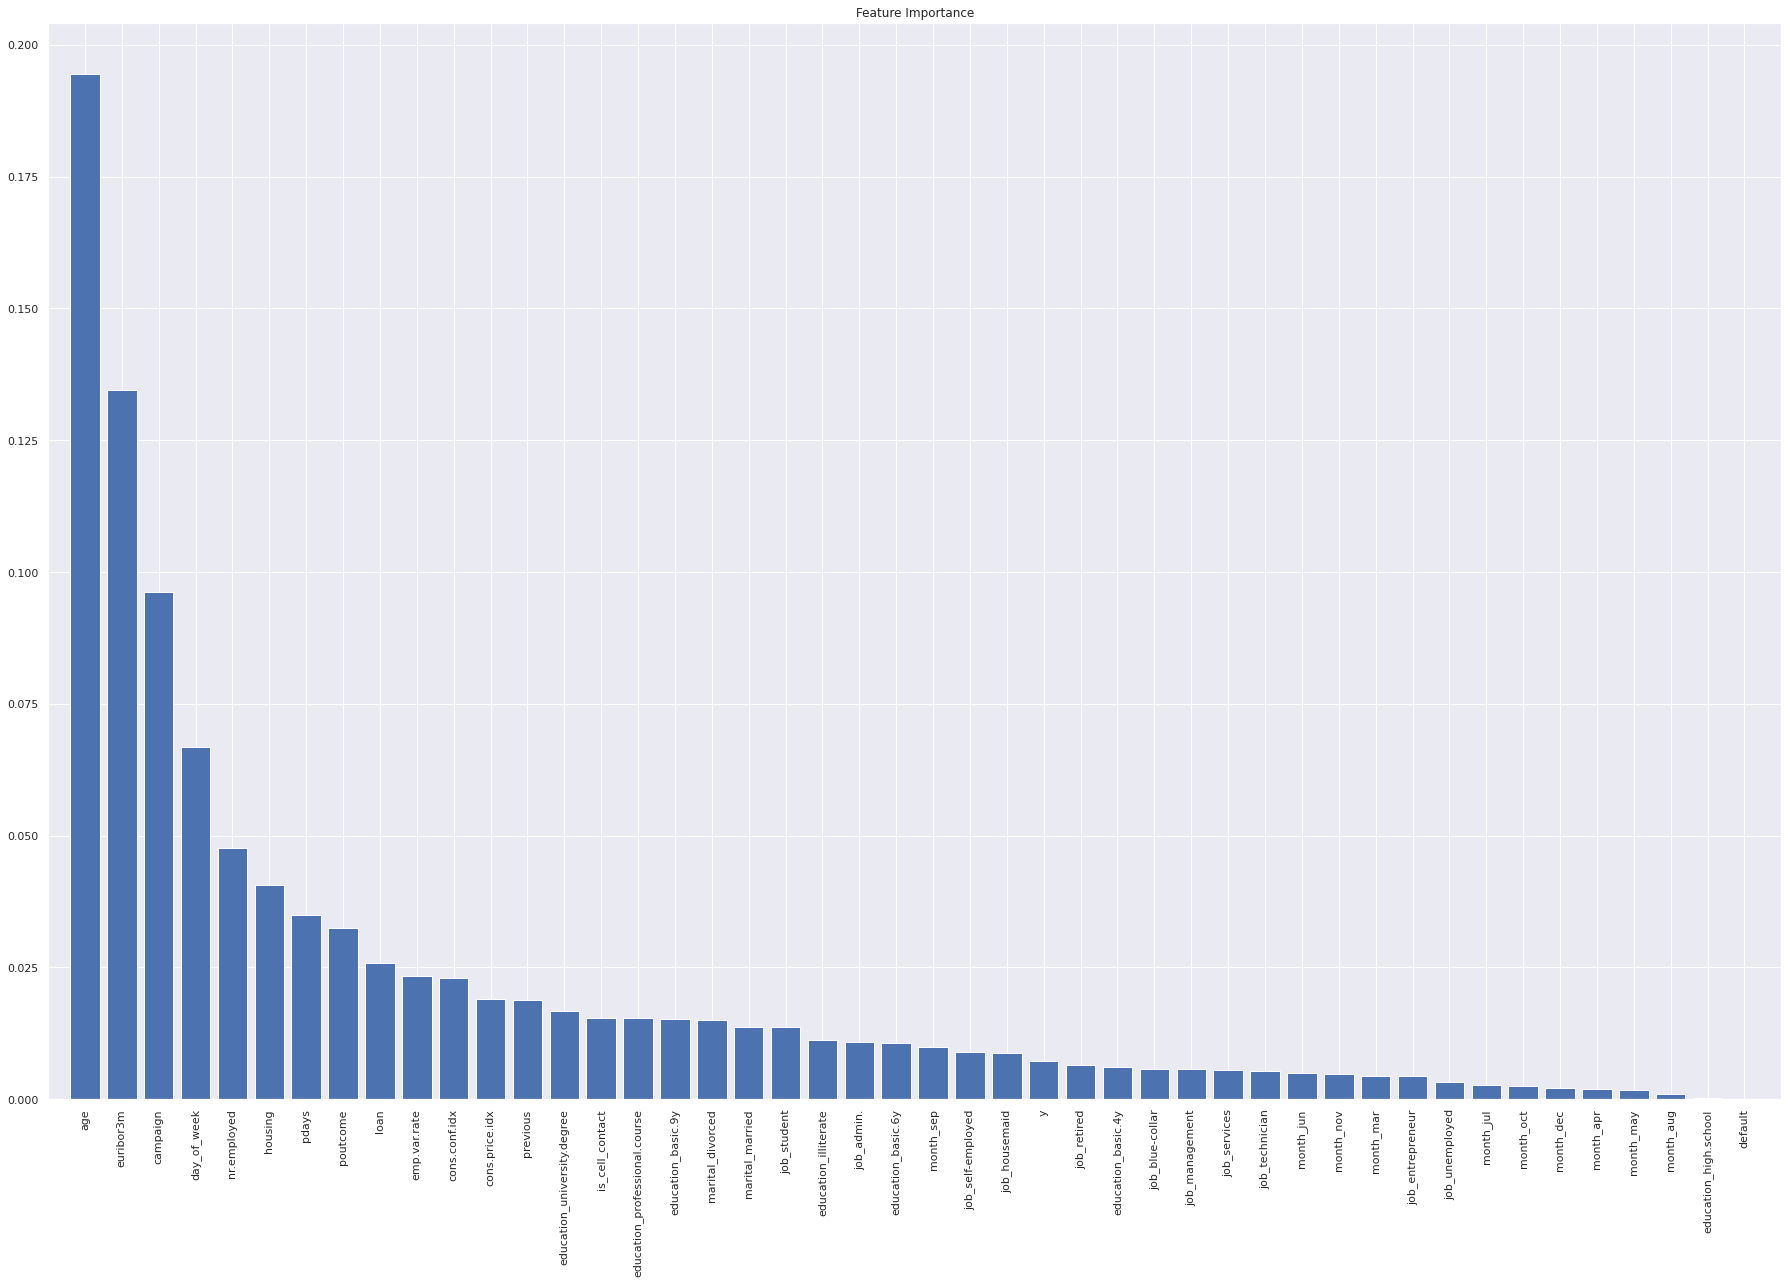

In [ ]:
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), 
        importances[indices],
        align='center')

plt.xticks(range(X.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

Base on random forest we could consider as the important feature the next:
age, euribor3m, campaign, day_of_week, nr.employed, housing, pdays.

#Feature engineering part 2

At the current step we need to fulfil dimensionality reduction. For this aim fist of all we have to bring the features to common variance:

In [ ]:
dr_features = ["emp.var.rate", "euribor3m", "nr.employed", "cons.price.idx", "previous", "is_cell_contact"]
dr_x = df.loc[:, dr_features].values

In [ ]:
dr_x = StandardScaler().fit_transform(dr_x)
pd.DataFrame(data=dr_x, columns=dr_features).head()

,emp.var.rate,euribor3m,nr.employed,cons.price.idx,previous,is_cell_contact
0,0.628508,0.691547,0.300907,0.711538,-0.341791,-1.304044
1,0.628508,0.691547,0.300907,0.711538,-0.341791,-1.304044
2,0.628508,0.691547,0.300907,0.711538,-0.341791,-1.304044
3,0.628508,0.691547,0.300907,0.711538,-0.341791,-1.304044
4,0.628508,0.691547,0.300907,0.711538,-0.341791,-1.304044


Create and fit PCA class:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pcomp = pca.fit_transform(dr_x)
pcomp

array([[-1.5242881 ,  0.81196133, -0.46830265,  0.22521876,  0.18259821,
         0.03654301],
       [-1.5242881 ,  0.81196133, -0.46830265,  0.22521876,  0.18259821,
         0.03654301],
       [-1.5242881 ,  0.81196133, -0.46830265,  0.22521876,  0.18259821,
         0.03654301],
       ...,
       [ 1.78987739,  1.4557245 , -0.711104  , -3.29758083,  0.37645991,
         0.12130326],
       [ 1.78987739,  1.4557245 , -0.711104  , -3.29758083,  0.37645991,
         0.12130326],
       [ 1.78987739,  1.4557245 , -0.711104  , -3.29758083,  0.37645991,
         0.12130326]])

Now we have explaned variance:

In [ ]:
pca.explained_variance_ratio_

array([0.64983079, 0.17021063, 0.12194106, 0.04933168, 0.00615759,
       0.00252825])

Let's build a chart to depict individual explained variance and how it changes with principal component selection:

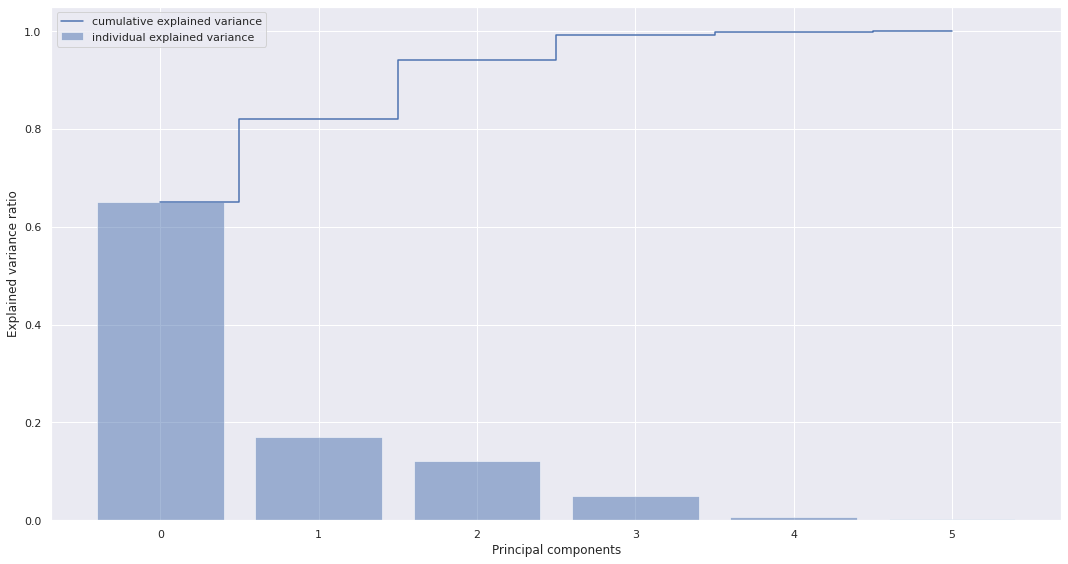

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
plt.bar(range(0, 6), pca.explained_variance_ratio_, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(0, 6), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

As we can see just one principal component explanes more than 60% of variance. However we could use the two components and cover more than 80% but the chose depends on different aproaches (somebody recomends cover just 50%, in other cases 80% and even 90%)

In [ ]:
pca = PCA(n_components=2)
pcomp = pca.fit_transform(dr_x)
pcomp

array([[-1.5242881 ,  0.81196133],
       [-1.5242881 ,  0.81196133],
       [-1.5242881 ,  0.81196133],
       ...,
       [ 1.78987739,  1.4557245 ],
       [ 1.78987739,  1.4557245 ],
       [ 1.78987739,  1.4557245 ]])

Now we have reduced features (more than 80% explaned variance) as ndarray, let's wrap it with pandas dataframe:

In [ ]:
dr_df = pd.DataFrame(data=pcomp, columns=["emp.var.rate_reduced1", "emp.var.rate_reduced2"])
dr_df

,emp.var.rate_reduced1,emp.var.rate_reduced2
0,-1.524288,0.811961
1,-1.524288,0.811961
2,-1.524288,0.811961
3,-1.524288,0.811961
4,-1.524288,0.811961
...,...,...
40187,1.789877,1.455724
40188,2.364166,2.443776
40189,1.789877,1.455724
40190,1.789877,1.455724


Let's rid of odd features:

In [ ]:
for col in dr_features:
  del df[col]

And build final dataset:

In [ ]:
df_pca = pd.concat([df.reset_index(drop=True), dr_df], sort=False, axis=1)

In [ ]:
df_pca

,age,default,housing,loan,day_of_week,campaign,pdays,poutcome,cons.conf.idx,y,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,marital_divorced,marital_married,marital_single,emp.var.rate_reduced1,emp.var.rate_reduced2
0,56,0,0,0,1,1,0,0.0,14.4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,-1.524288,0.811961
1,57,0,0,0,1,1,0,0.0,14.4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,-1.524288,0.811961
2,37,0,1,0,1,1,0,0.0,14.4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,-1.524288,0.811961
3,40,0,0,0,1,1,0,0.0,14.4,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,-1.524288,0.811961
4,56,0,0,1,1,1,0,0.0,14.4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,-1.524288,0.811961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40187,37,0,1,0,5,1,0,0.0,0.0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1.789877,1.455724
40188,29,0,1,0,5,1,9,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,2.364166,2.443776
40189,46,0,0,0,5,1,0,0.0,0.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1.789877,1.455724
40190,56,0,1,0,5,2,0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1.789877,1.455724


**Now we prepared the dataset for a model fitting.**
______________________

In addition, we would fulfill singularity decomposition for cross-checking:

In [ ]:
from sklearn.decomposition import TruncatedSVD


svd = TruncatedSVD()
result = svd.fit_transform(dr_x)
result

array([[-1.5242881 ,  0.81196133],
       [-1.5242881 ,  0.81196133],
       [-1.5242881 ,  0.81196133],
       ...,
       [ 1.78987739,  1.4557245 ],
       [ 1.78987739,  1.4557245 ],
       [ 1.78987739,  1.4557245 ]])

As we can see the result pretty much the same as in case of PCA.